# Initialisation

## Installation des librairies

In [ ]:
%pip install -r requirements.txt

## Importation des librairies

In [1]:
import os
import pickle
import time
import zipfile
import cv2
import gdown
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import plot_model

## Verifier que la dataset existe

In [2]:
# Define the folder name and download URL
download_url = "https://drive.google.com/uc?id=1h4ek1Gh5qYY7UfEWcnV-K0uZ-oaaxUPj"

# Check if the folder exists
if os.path.exists('FaceMaskDataset'):
    print(f"The folder 'FaceMaskDataset' already exists.")
else:
    # Download the zip file
    print("Downloading the dataset zip file...")
    gdown.download(download_url, f"FaceMaskDataset.zip", quiet=False)

    # Unzip the downloaded file without creating an additional directory
    print("Unzipping the dataset...")
    with zipfile.ZipFile(f"FaceMaskDataset.zip", 'r') as zip_ref:
        zip_ref.extractall()
    print("Extraction complete.")

    # Remove the zip file after extraction
    os.remove(f"FaceMaskDataset.zip")
    print(f"Removed 'FaceMaskDataset.zip'.")

print("Process completed.")

The folder 'FaceMaskDataset' already exists.
Process completed.


## Definir des variables globales

In [3]:
#nombre d'epochs lors de l'entrainement 
epochs=35

## Definir les fonctions a utlisier plus tard

In [4]:
# Function to display images and labels with a specified title
def display_images(images, labels, title):
    plt.figure(figsize=(12, 6))
    plt.suptitle(title, fontsize=14)
    for i in range(len(images)):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

#visualize fitting of model
def check_metrics(history, figure_name):

    train = history[f'{figure_name}']
    val = history[f'val_{figure_name}']

    epochs = range(1, len(train) + 1)
    plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')
    plt.plot(epochs, val, 'b', label=f'Test {figure_name}')
    plt.title(f'Training and Test {figure_name}')
    plt.xlabel('Epochs')
    plt.ylabel(f'{figure_name}')
    plt.legend()
    plt.show()

#visualize the confusion matrix
def plot_confusion(model):
    # Predicting labels using the model
    predictions = model.predict(test_data)
    predicted_labels = np.argmax(predictions, axis=1)  # Convert softmax output to class labels

    # Get true labels from the test data
    true_labels = test_data.classes

    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def test_epoch_time(model):
    start_time = time.time()
    predictions = model.predict(test_data)
    end_time = time.time()

    epoch_time = end_time - start_time
    return epoch_time

def plot_training_accuracy(models):
    plt.figure(figsize=(10, 6))
    for model_name, model_dict in models.items():
        history = model_dict['history']
        plt.plot(history['accuracy'], label=model_name)

    plt.xlabel('Epochs')
    plt.ylabel('Training Accuracy')
    plt.title('Training Accuracy Improvement Through Epochs')
    plt.legend()
    plt.show()

def plot_validation_accuracy(models):
    plt.figure(figsize=(10, 6))
    for model_name, model_dict in models.items():
        history = model_dict['history']
        plt.plot(history['val_accuracy'], label=model_name)

    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy Improvement Through Epochs')
    plt.legend()
    plt.show()

def plot_epoch_times(models):
    epoch_times = []
    model_names = []
    for model_name, model_dict in models.items():
        epoch_time = test_epoch_time(model_dict['model'])
        epoch_times.append(epoch_time)
        model_names.append(model_name)

    plt.figure(figsize=(10, 6))
    plt.bar(model_names, epoch_times, color='skyblue')
    plt.xlabel('Models')
    plt.ylabel('Epoch Time (seconds)')
    plt.title('Epoch Times for Each Model')
    plt.xticks(rotation=45)
    plt.show()

def plot_number_of_parameters(models):
    num_params = []
    model_names = []
    for model_name, model_dict in models.items():
        num_param = model_dict['model'].count_params()
        num_params.append(num_param)
        model_names.append(model_name)

    plt.figure(figsize=(10, 6))
    plt.bar(model_names, num_params, color='salmon')
    plt.xlabel('Models')
    plt.ylabel('Number of Parameters')
    plt.title('Number of Parameters in Each Model')
    plt.xticks(rotation=45)
    plt.show()

def plot_confusion_matrices(models):
    for model_name, model_dict in models.items():
        predictions = model_dict['model'].predict(test_data)
        predicted_labels = np.argmax(predictions, axis=1)
        true_labels = test_data.classes

        cm = confusion_matrix(true_labels, predicted_labels)

        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for {model_name}')
        plt.show()

## Limiting GPU memory growth

In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Visualisation des donnees

### Importer les donnees

In [6]:
train_dir =r'FaceMaskDataset/test'
test_dir =r'FaceMaskDataset/train'

In [7]:

train_dir =r'FaceMaskDataset/test224'
test_dir =r'FaceMaskDataset/train224'

datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(train_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=True)  

test_data = datagen.flow_from_directory(test_dir, target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=True)

Found 3060 images belonging to 2 classes.


Found 5944 images belonging to 2 classes.


In [8]:
print(train_data.class_indices)

{'face': 0, 'maskface': 1}


### Visualiser quelques donnees

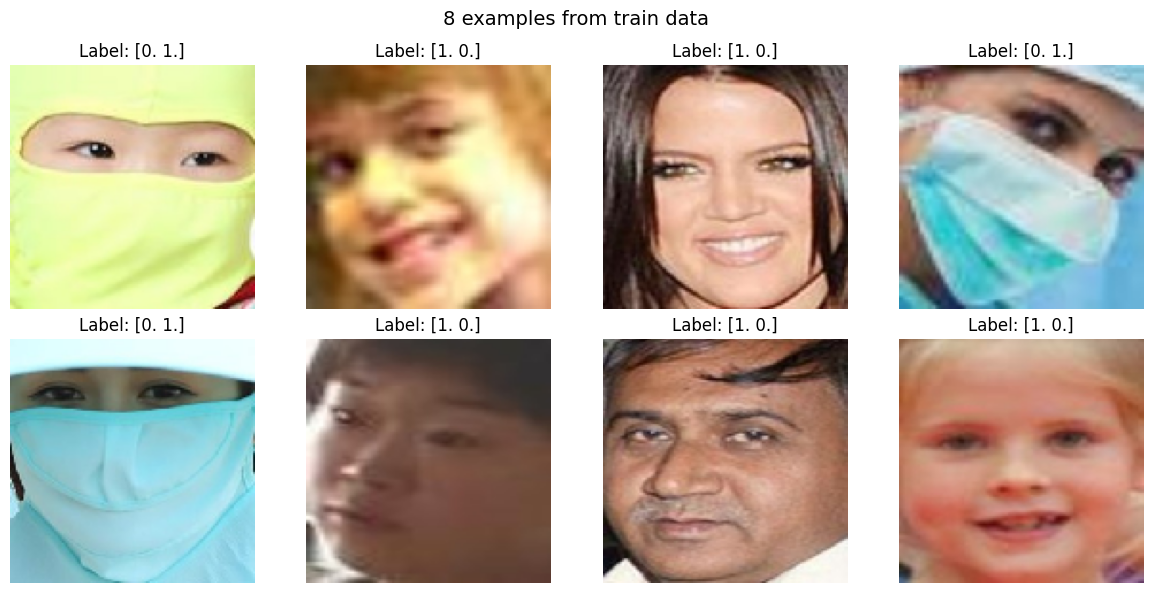

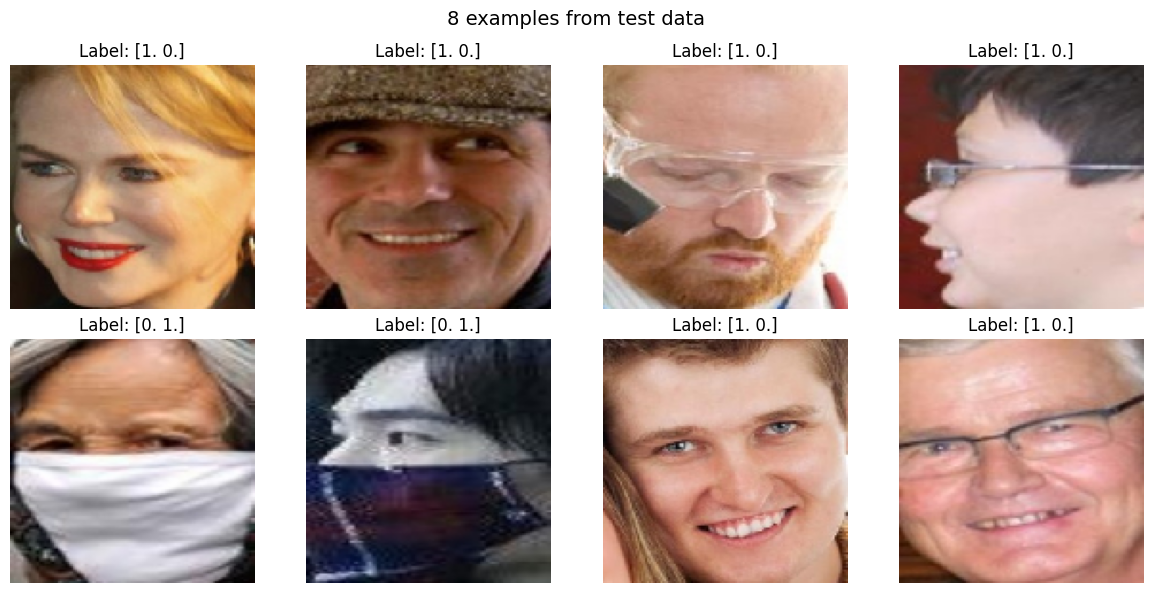

In [9]:
# Get a batch of images and labels from the training dataset
train_images, train_labels = train_data.next()

# Get a batch of images and labels from the test dataset
test_images, test_labels = test_data.next()

# Display a few images from the training dataset with a label
display_images(train_images[:8], train_labels[:8], "8 examples from train data")

# Display a few images from the test dataset with a label
display_images(test_images[:8], test_labels[:8], "8 examples from test data")

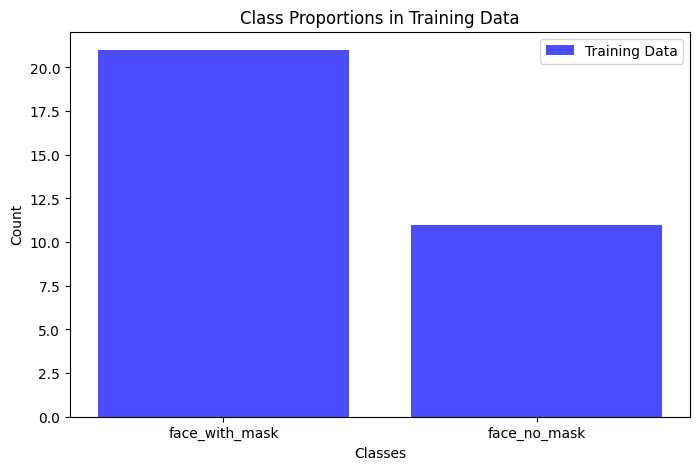

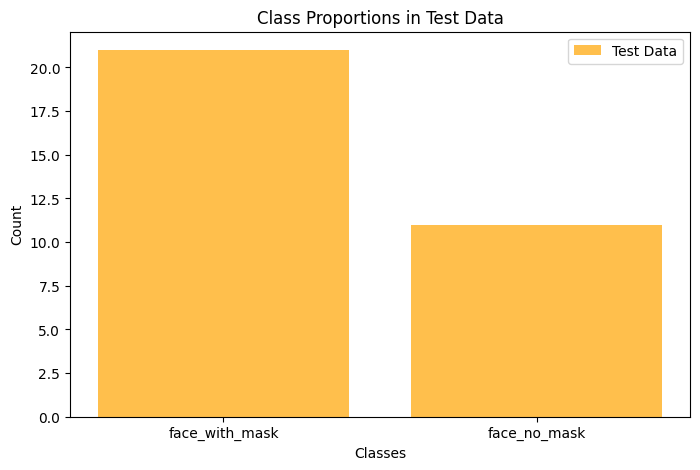

In [10]:
# Count the occurrences of each class in the training dataset
train_class_counts = np.sum(train_labels, axis=0)

# Count the occurrences of each class in the test dataset
test_class_counts = np.sum(test_labels, axis=0)

# Labels for the classes
class_labels = ['face_with_mask', 'face_no_mask']

# Bar plot for class proportions in the training dataset
plt.figure(figsize=(8, 5))
plt.bar(class_labels, train_class_counts, color='blue', alpha=0.7, label='Training Data')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Proportions in Training Data')
plt.legend()
plt.show()

# Bar plot for class proportions in the test dataset
plt.figure(figsize=(8, 5))
plt.bar(class_labels, test_class_counts, color='orange', alpha=0.7, label='Test Data')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Proportions in Test Data')
plt.legend()
plt.show()


# Evaluation des modeles (sans augmentation de données)

## Definition des modeles 

In [11]:
models = {}

# Modele ANN Simple
simple_ann_model = Sequential([
    Flatten(input_shape=(128, 128, 3)),  
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])
simple_ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
models['simple_ann_model'] = {'model': simple_ann_model, 'history': None}

# Modele ANN Complexe
complicated_ann_model = Sequential([
    Flatten(input_shape=(128, 128, 3)), 
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(128, activation='sigmoid'),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')
])
complicated_ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
models['complicated_ann_model'] = {'model': complicated_ann_model, 'history': None}

# Modele CNN Simple
simple_cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])
simple_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
models['simple_cnn_model'] = {'model': simple_cnn_model, 'history': None}

# Modele CNN Complexe
complicated_cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])
complicated_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
models['complicated_cnn_model'] = {'model': complicated_cnn_model, 'history': None}

# Transfer Learning using VGG16
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

transfer_vgg_model = Sequential([
    vgg_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

transfer_vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
models['transfer_vgg_model'] = {'model': transfer_vgg_model, 'history': None}

# Transfer Learning using VGG16 with unfrozen layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

transfer_vgg_model_unfrozen = Sequential([
    vgg_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

for layer in transfer_vgg_model_unfrozen.layers[0].layers[-5:]:
    layer.trainable = True

transfer_vgg_model_unfrozen.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
models['transfer_vgg_model_unfrozen'] = {'model': transfer_vgg_model_unfrozen, 'history': None}

# Transfer Learning using ResNet50
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

transfer_resnet_model = Sequential([
    resnet_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

transfer_resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
models['transfer_resnet_model'] = {'model': transfer_resnet_model, 'history': None}

## Entrainement des modeles

In [12]:
# Check if the directory exists, if not, create it
save_dir = 'saved_models/without_data_augmentation'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Loop through models
for model_name, model_info in models.items():
    model = model_info['model']
    model_history = model_info['history']

    # Check if the model and history files exist
    model_filename = os.path.join(save_dir, f'{model_name}_model.h5')
    history_filename = os.path.join(save_dir, f'{model_name}_history.pkl')

    if os.path.exists(model_filename) and os.path.exists(history_filename):
        # Load existing model and history
        loaded_model = load_model(model_filename)
        with open(history_filename, 'rb') as history_file:
            loaded_history = pickle.load(history_file)

        # Update the model and history in the dictionary
        models[model_name]['model'] = loaded_model
        models[model_name]['history'] = loaded_history

        print(f"Loaded existing model and history for {model_name}")
    else:
        print(f"Training model {model_name}")
         # Define ModelCheckpoint callback to save the best model during training

        history = model.fit(train_data, epochs=epochs, 
                        validation_data=test_data)
        model.save(model_filename)

        # Save the history
        with open(history_filename, 'wb') as history_file:
            pickle.dump(history.history, history_file)

        # Update the model and history in the dictionary
        models[model_name]['history'] = history.history

        print(f"Trained and saved model and history for {model_name}")

Loaded existing model and history for simple_ann_model
Loaded existing model and history for complicated_ann_model
Loaded existing model and history for simple_cnn_model
Loaded existing model and history for complicated_cnn_model
Loaded existing model and history for transfer_vgg_model
Loaded existing model and history for transfer_vgg_model_unfrozen
Loaded existing model and history for transfer_resnet_model


## Evalutation Individuelle des modeles

### ANN Simple

In [13]:
chosen_model_name = 'simple_ann_model'
history = models[chosen_model_name]['history']
model = models[chosen_model_name]['model']

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 128)               6291584   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 6,299,970
Trainable params: 6,299,970
Non-trainable params: 0
_________________________________________________________________


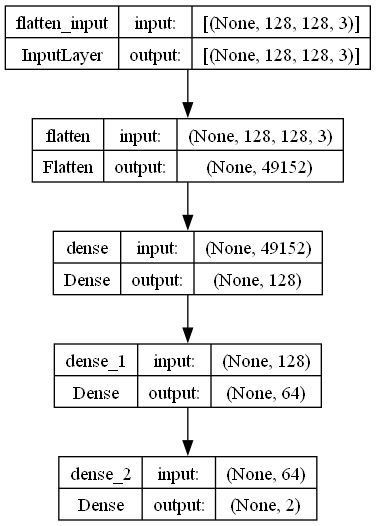

In [15]:
plot_model(model, show_shapes=True, show_layer_names=True)

C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


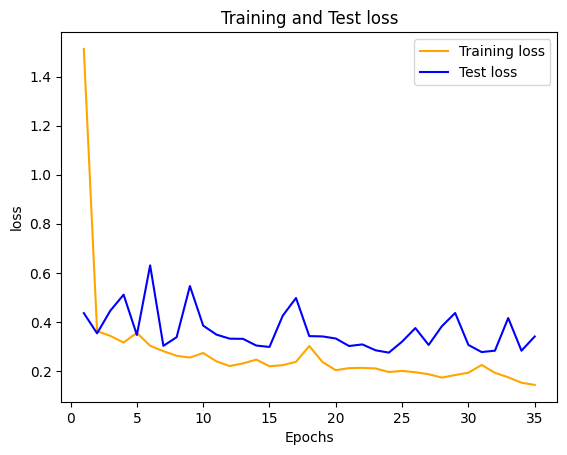

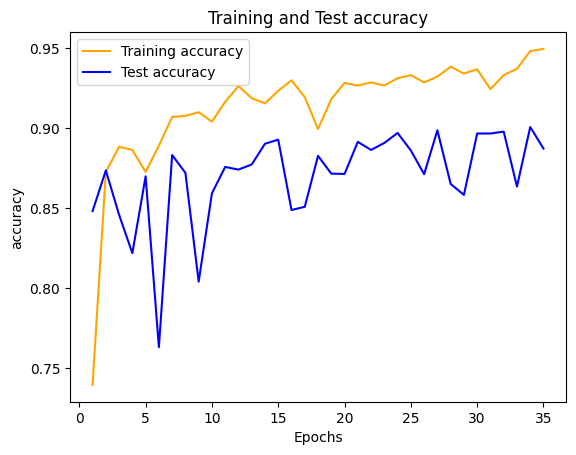

In [16]:
check_metrics(history, 'loss')
check_metrics(history, 'accuracy')

186/186 [==============================] - 10s 47ms/step


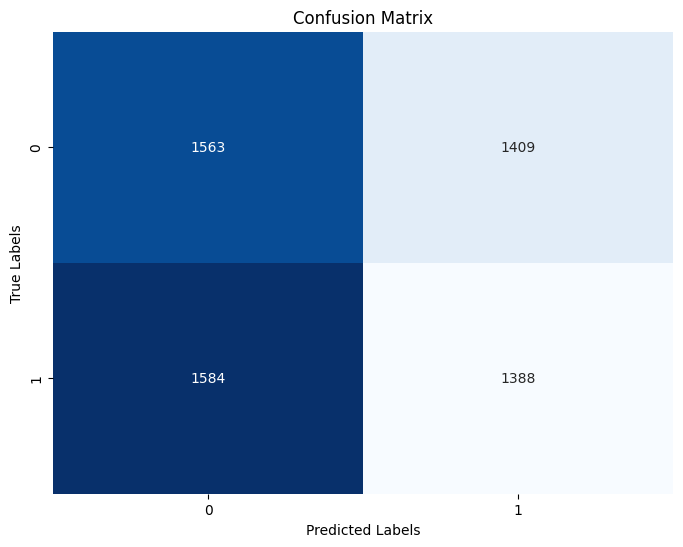

In [17]:
plot_confusion(model)

In [18]:
test_epoch_time(model)

186/186 [==============================] - 8s 45ms/step


8.587150573730469

### ANN Complexe

In [19]:
chosen_model_name = 'complicated_ann_model'
history = models[chosen_model_name]['history']
model = models[chosen_model_name]['model']

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 49152)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               12583168  
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)               

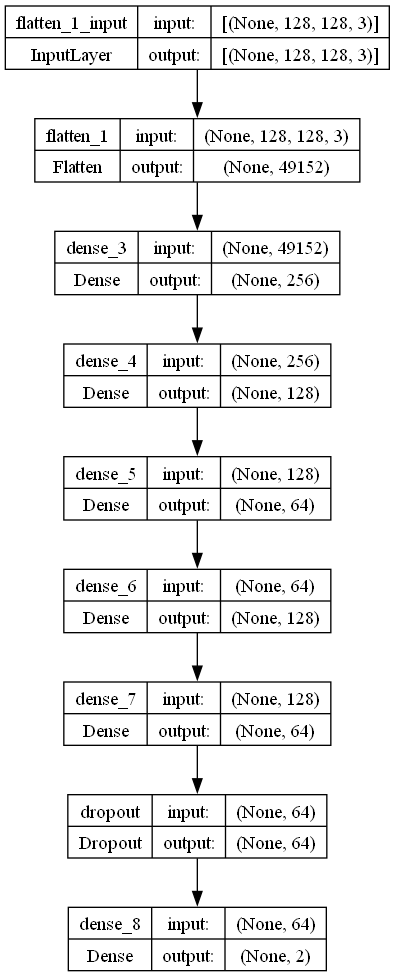

In [21]:
plot_model(model, show_shapes=True, show_layer_names=True)

C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


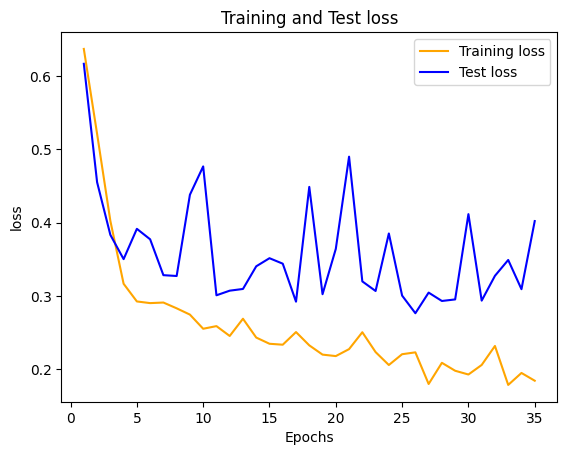

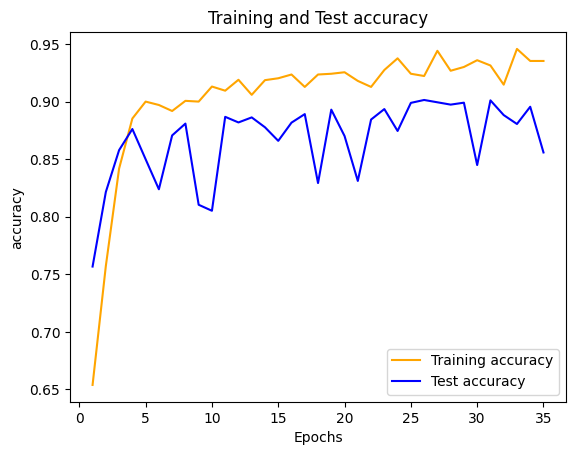

In [22]:
check_metrics(history, 'loss')
check_metrics(history, 'accuracy')

186/186 [==============================] - 9s 46ms/step


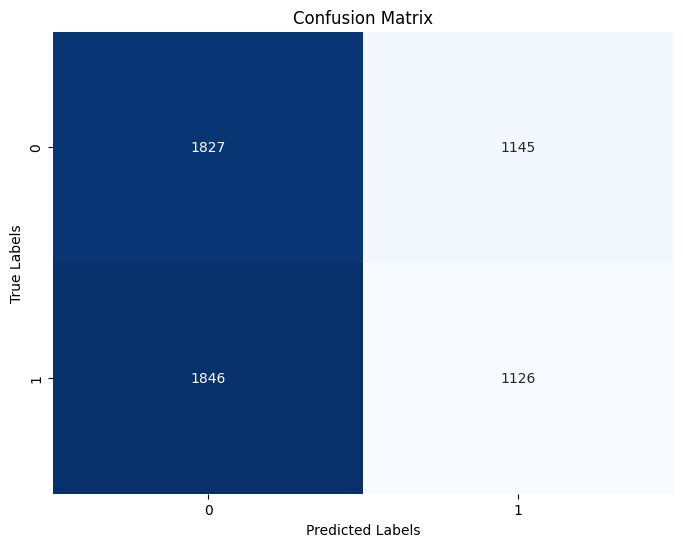

In [23]:
plot_confusion(model)

In [24]:
test_epoch_time(model)

  1/186 [..............................] - ETA: 21s

186/186 [==============================] - 8s 45ms/step


8.714449644088745

### CNN Simple

In [25]:
chosen_model_name = 'simple_cnn_model'
history = models[chosen_model_name]['history']
model = models[chosen_model_name]['model']

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 57600)             0         
                                                                 
 dense_9 (Dense)             (None, 128)              

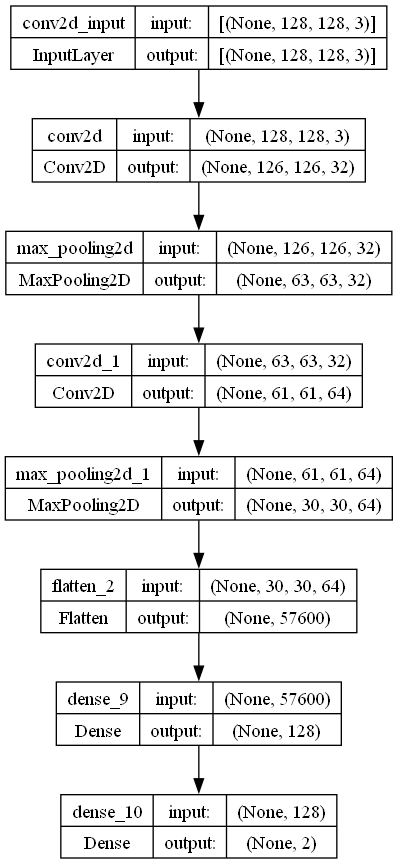

In [27]:
plot_model(model, show_shapes=True, show_layer_names=True)

C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


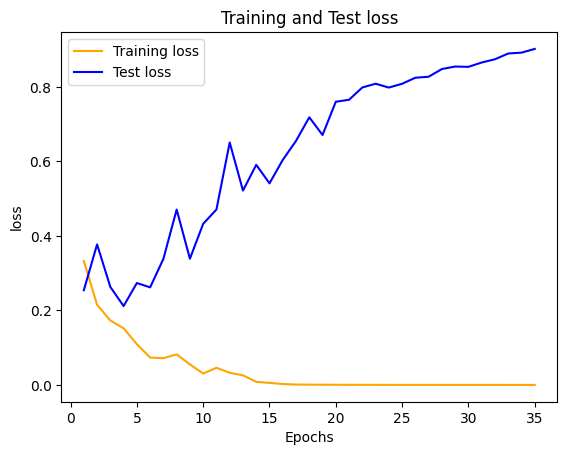

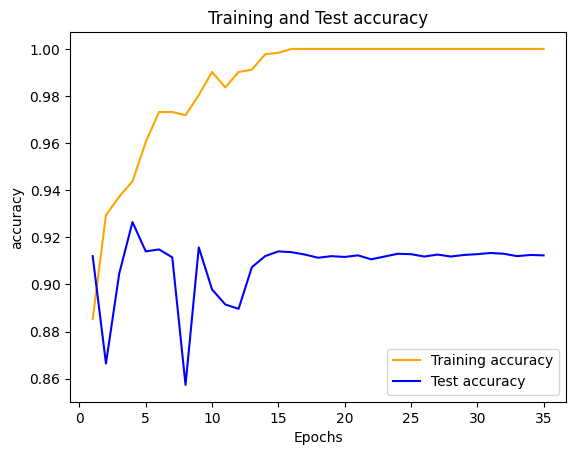

In [28]:
check_metrics(history, 'loss')
check_metrics(history, 'accuracy')

186/186 [==============================] - 13s 47ms/step


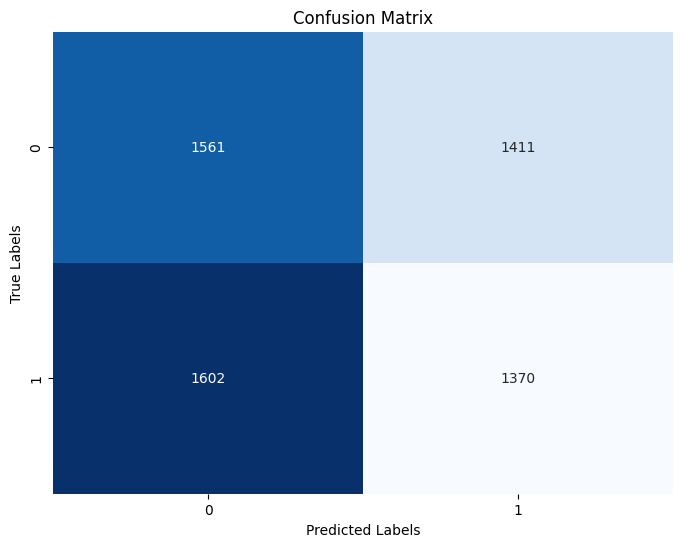

In [29]:
plot_confusion(model)

In [30]:
test_epoch_time(model)

186/186 [==============================] - 8s 44ms/step


8.593021154403687

### CNN Complexe

In [31]:
chosen_model_name = 'complicated_cnn_model'
history = models[chosen_model_name]['history']
model = models[chosen_model_name]['model']

In [32]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 128)     

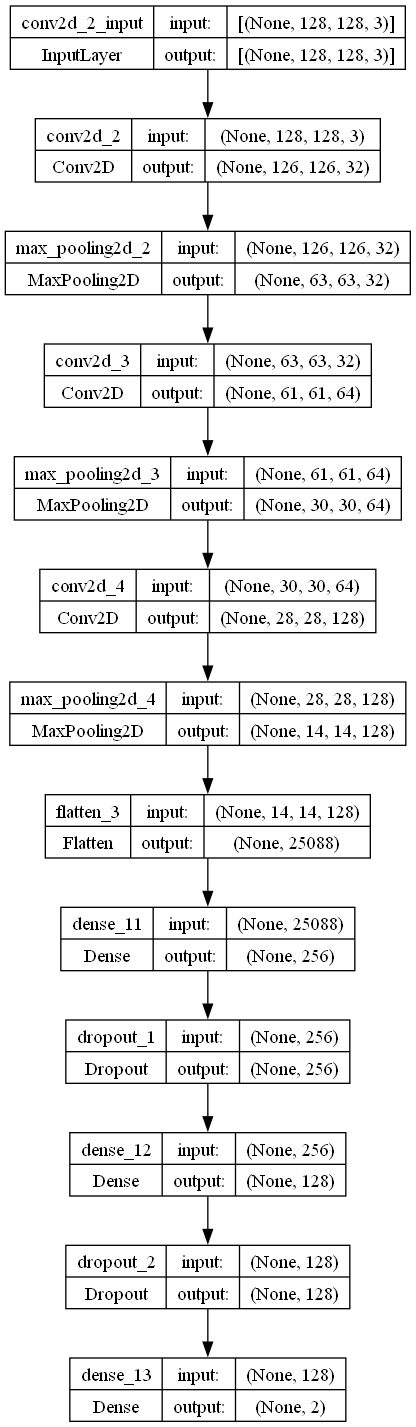

In [33]:
plot_model(model, show_shapes=True, show_layer_names=True)

C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


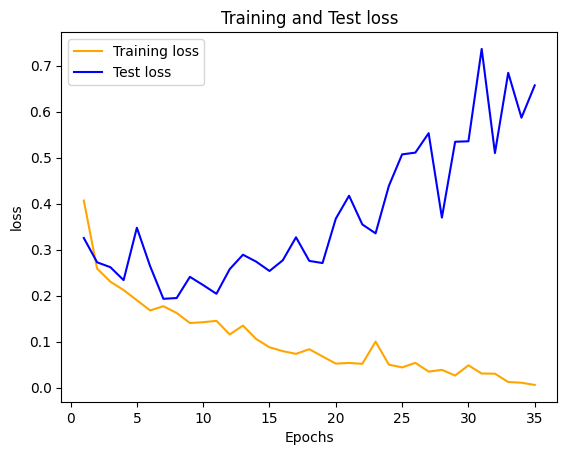

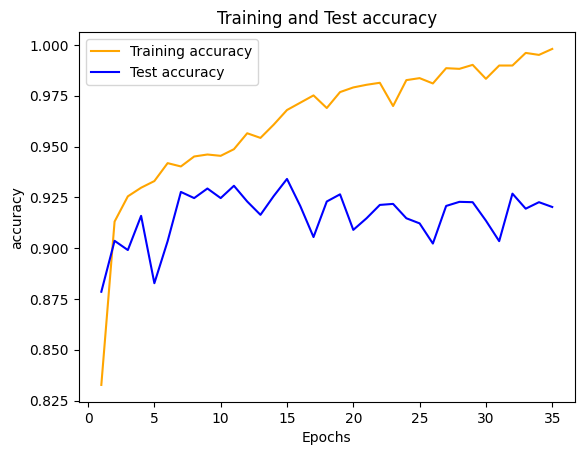

In [34]:
check_metrics(history, 'loss')
check_metrics(history, 'accuracy')

186/186 [==============================] - 8s 42ms/step


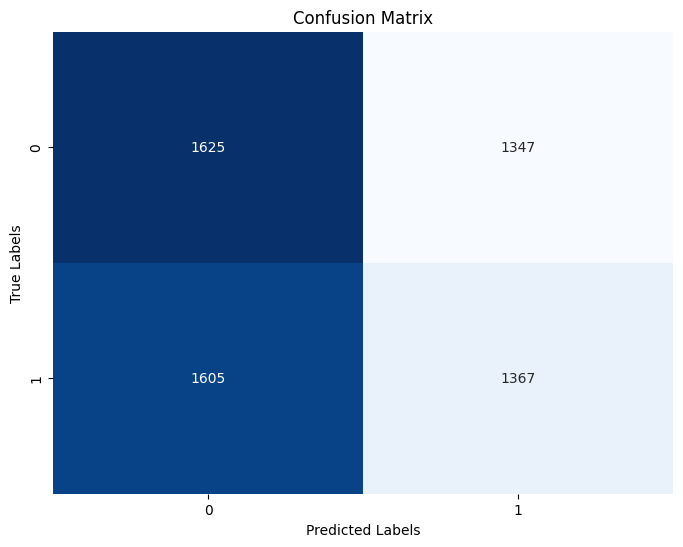

In [35]:
plot_confusion(model)

In [36]:
test_epoch_time(model)

186/186 [==============================] - 8s 42ms/step


8.03943419456482

### Transfer learning avec vgg (frozen base)

In [37]:
chosen_model_name = 'transfer_vgg_model'
history = models[chosen_model_name]['history']
model = models[chosen_model_name]['model']

In [38]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_14 (Dense)            (None, 256)               2097408   
                                                                 
 dense_15 (Dense)            (None, 128)               32896     
                                                                 
 dense_16 (Dense)            (None, 2)                 258       
                                                                 
Total params: 16,845,250
Trainable params: 16,845,250
Non-trainable params: 0
_________________________________________________________________


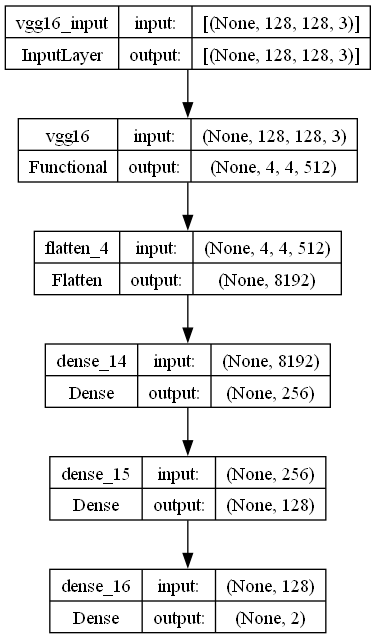

In [39]:
plot_model(model, show_shapes=True, show_layer_names=True)

C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


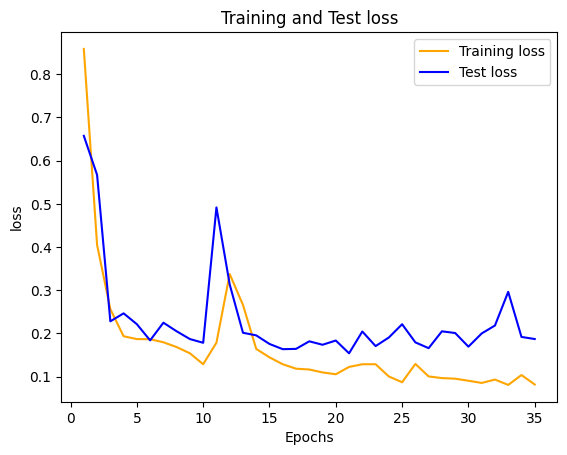

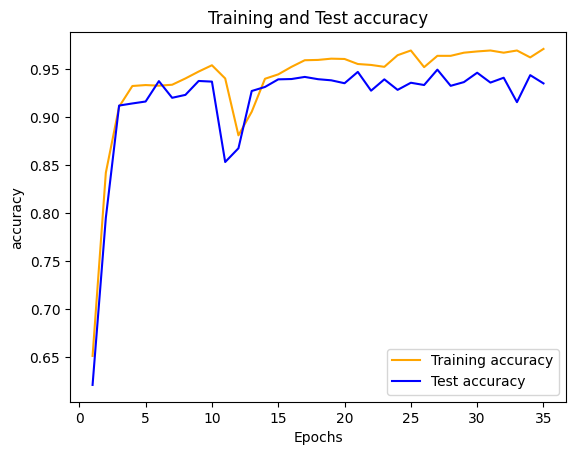

In [40]:
check_metrics(history, 'loss')
check_metrics(history, 'accuracy')

186/186 [==============================] - 16s 64ms/step


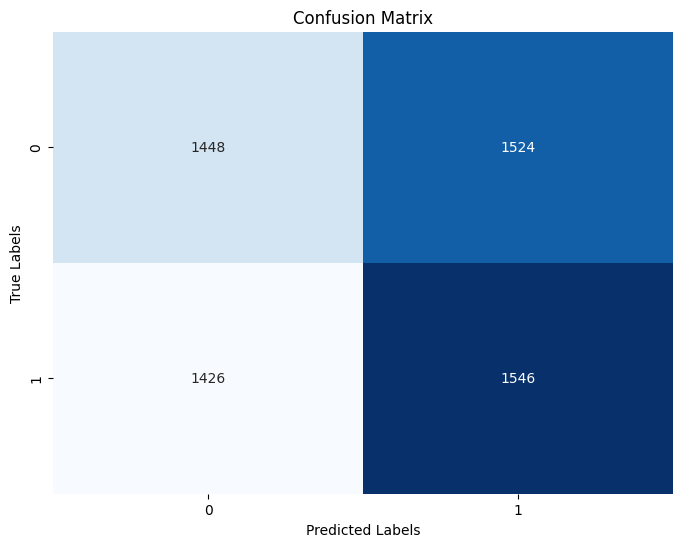

In [41]:
plot_confusion(model)

In [42]:
test_epoch_time(model)

186/186 [==============================] - 10s 52ms/step


10.065539598464966

### Transfer learning avec vgg

In [43]:
chosen_model_name = 'transfer_vgg_model_unfrozen'
history = models[chosen_model_name]['history']
model = models[chosen_model_name]['model']

In [44]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_17 (Dense)            (None, 256)               2097408   
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                                 
 dense_19 (Dense)            (None, 2)                 258       
                                                                 
Total params: 16,845,250
Trainable params: 16,845,250
Non-trainable params: 0
_________________________________________________________________


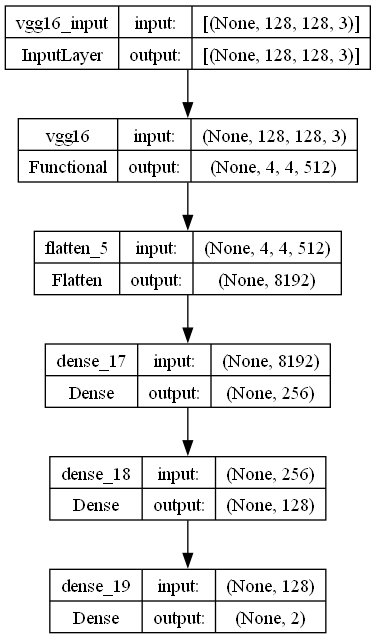

In [45]:
plot_model(model, show_shapes=True, show_layer_names=True)

C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


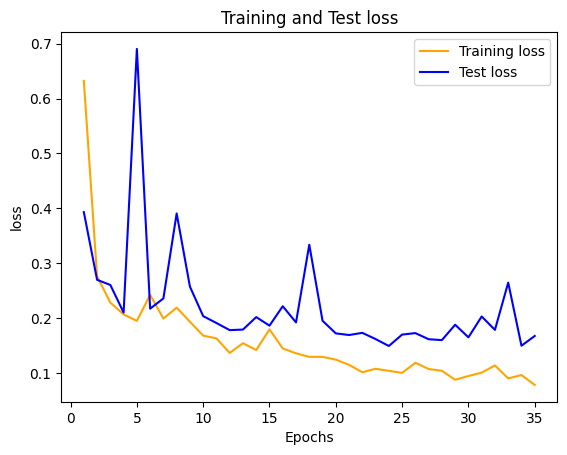

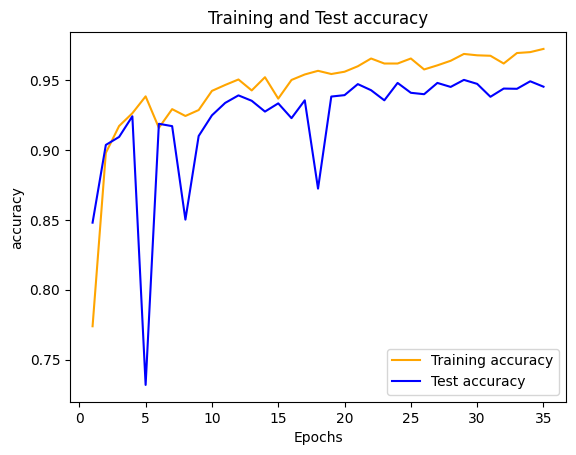

In [46]:
check_metrics(history, 'loss')
check_metrics(history, 'accuracy')

186/186 [==============================] - 10s 52ms/step


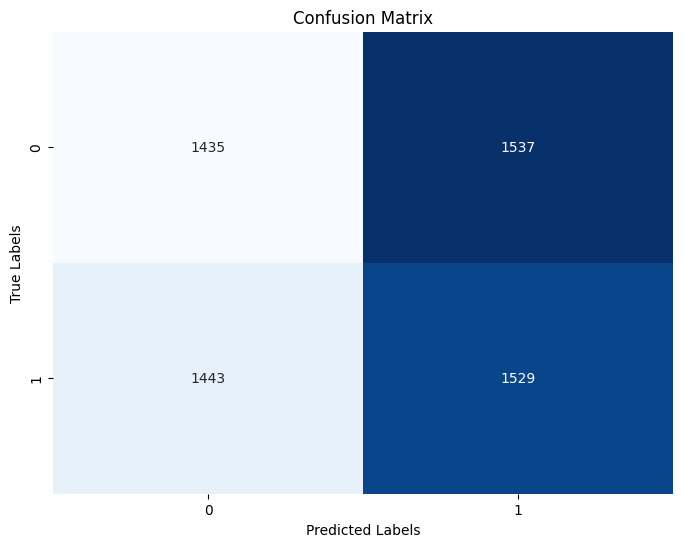

In [47]:
plot_confusion(model)

In [48]:
test_epoch_time(model)

186/186 [==============================] - 10s 52ms/step


9.922008037567139

### Transfer learning avec resnet (frozen base)

In [49]:
chosen_model_name = 'transfer_resnet_model'
history = models[chosen_model_name]['history']
model = models[chosen_model_name]['model']

In [50]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_6 (Flatten)         (None, 32768)             0         
                                                                 
 dense_20 (Dense)            (None, 256)               8388864   
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 dense_22 (Dense)            (None, 2)                 258       
                                                                 
Total params: 32,009,730
Trainable params: 31,956,610
Non-trainable params: 53,120
_________________________________________________________________


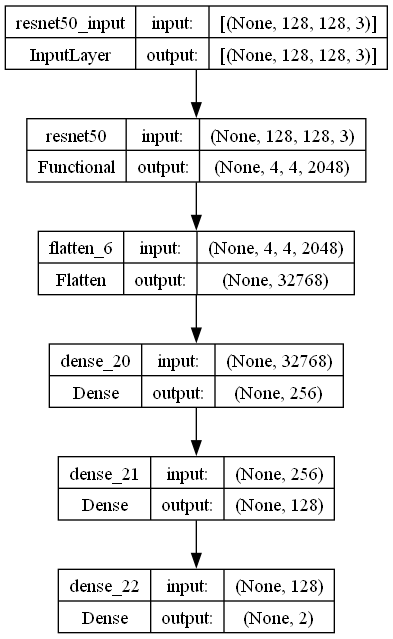

In [51]:
plot_model(model, show_shapes=True, show_layer_names=True)

C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


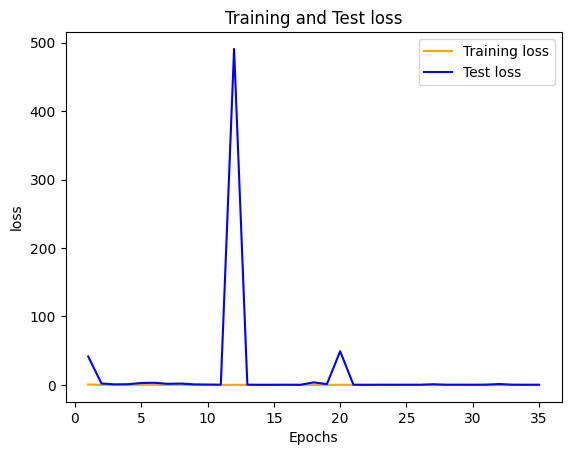

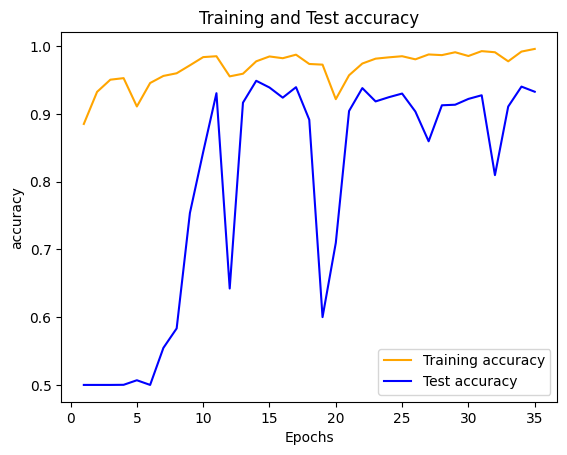

In [52]:
check_metrics(history, 'loss')
check_metrics(history, 'accuracy')

186/186 [==============================] - 13s 56ms/step


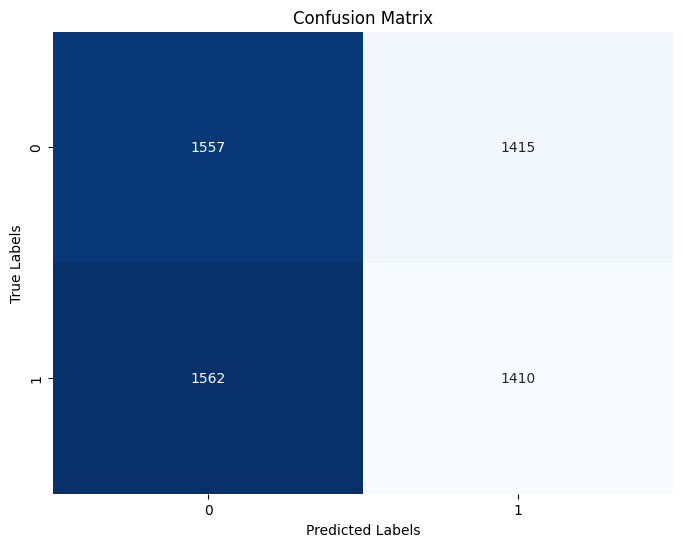

In [53]:
plot_confusion(model)

In [54]:
test_epoch_time(model)

186/186 [==============================] - 10s 56ms/step


10.739975929260254

## Comparaison des modeles

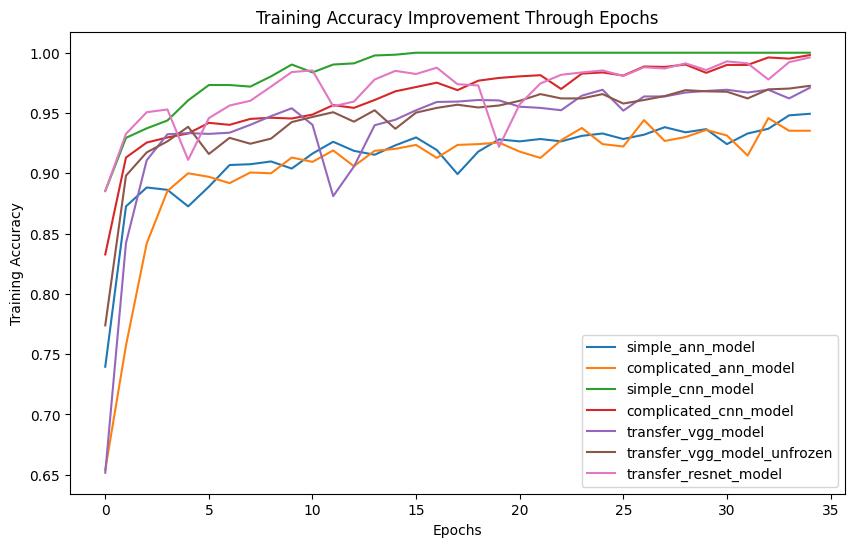

In [55]:
plot_training_accuracy(models)

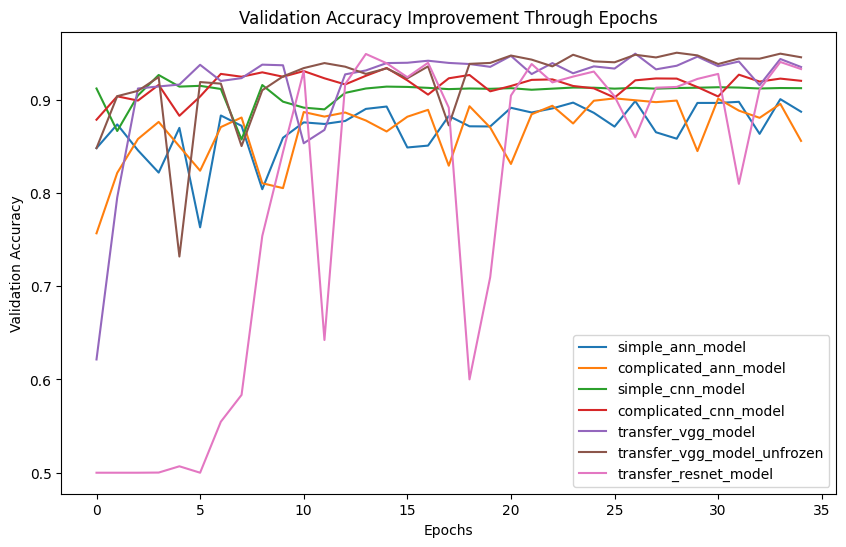

In [56]:
plot_validation_accuracy(models)

186/186 [==============================] - 10s 52ms/step


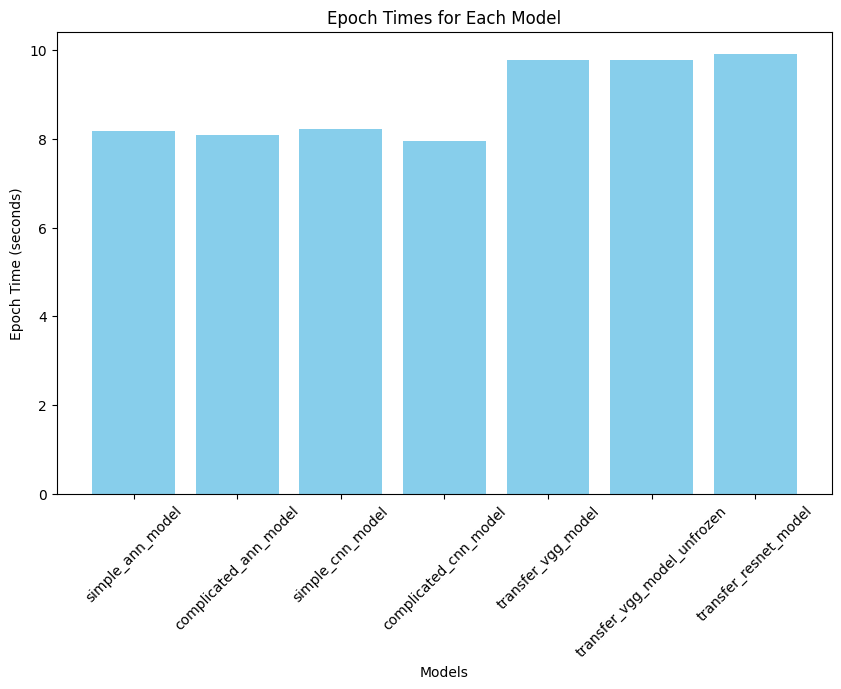

In [57]:
plot_epoch_times(models)

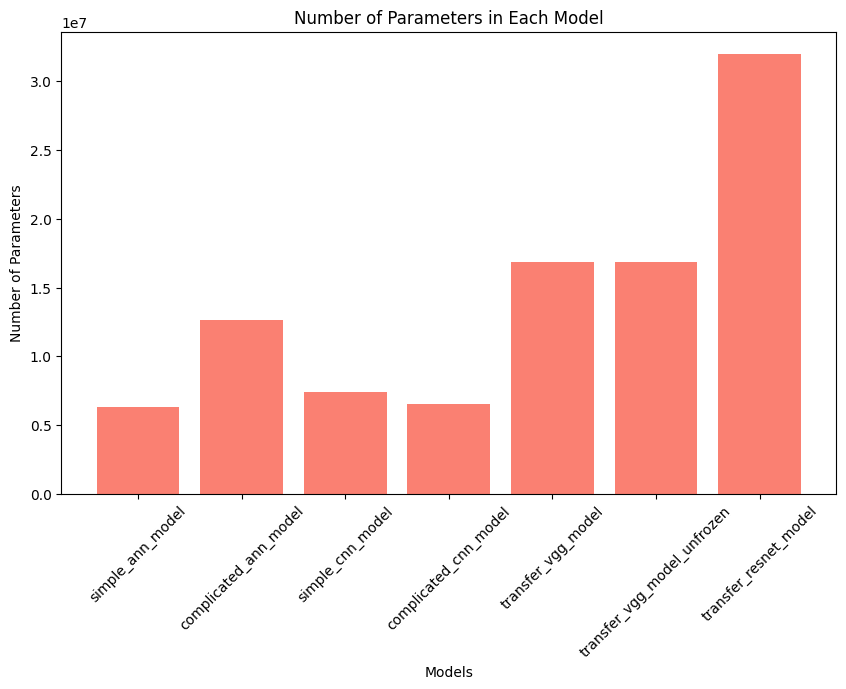

In [58]:
plot_number_of_parameters(models)

186/186 [==============================] - 8s 41ms/step


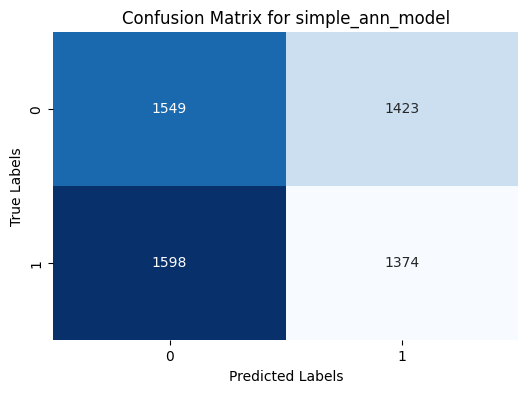

186/186 [==============================] - 8s 41ms/step


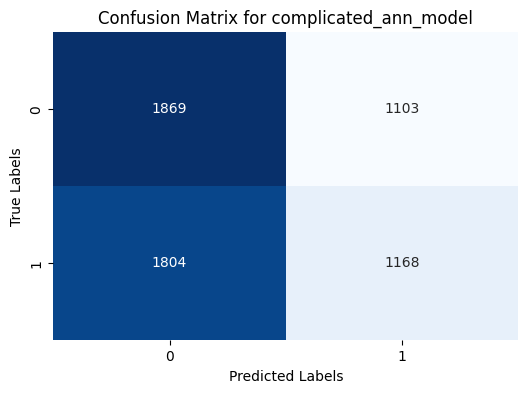

186/186 [==============================] - 8s 41ms/step


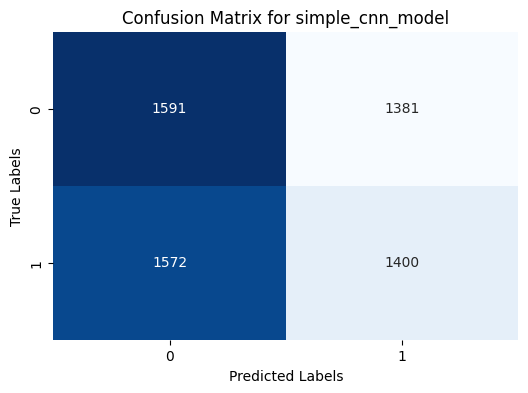

186/186 [==============================] - 8s 41ms/step


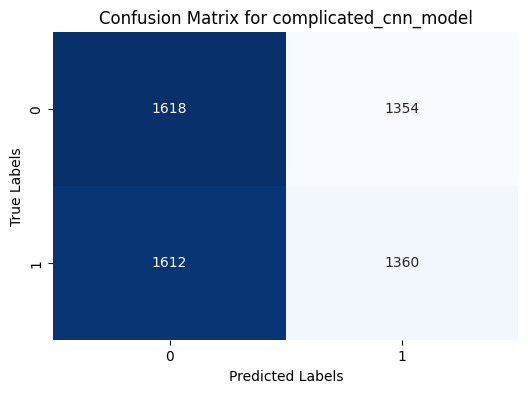

186/186 [==============================] - 10s 54ms/step


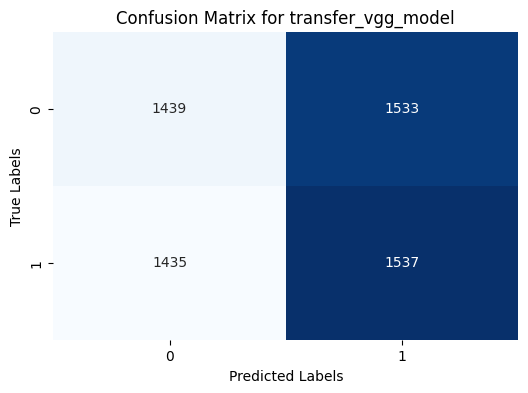

186/186 [==============================] - 10s 52ms/step


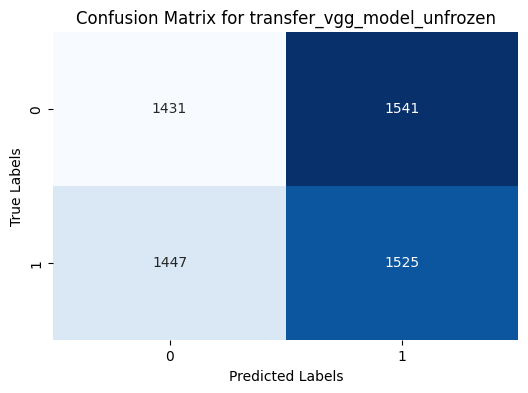

186/186 [==============================] - 10s 53ms/step


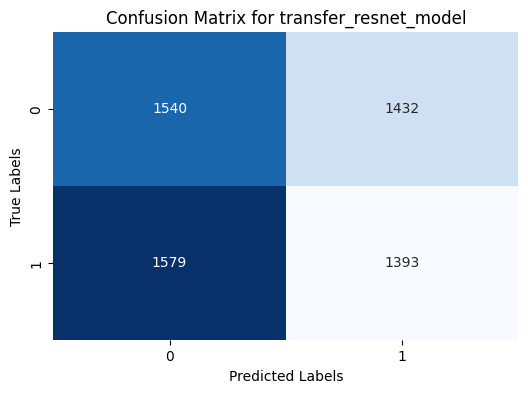

In [59]:
plot_confusion_matrices(models)

# Evaluation des modeles (avec aumentation de données)

## Definition des modeles 

In [60]:
models_augmented = {}

# Modele ANN Simple
simple_ann_model = Sequential([
    Flatten(input_shape=(128, 128, 3)),  
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])
simple_ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
models_augmented['simple_ann_model'] = {'model': simple_ann_model, 'history': None}

# Modele ANN Complexe
complicated_ann_model = Sequential([
    Flatten(input_shape=(128, 128, 3)), 
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(128, activation='sigmoid'),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')
])
complicated_ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
models_augmented['complicated_ann_model'] = {'model': complicated_ann_model, 'history': None}

# Modele CNN Simple
simple_cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])
simple_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
models_augmented['simple_cnn_model'] = {'model': simple_cnn_model, 'history': None}

# Modele CNN Complexe
complicated_cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])
complicated_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
models_augmented['complicated_cnn_model'] = {'model': complicated_cnn_model, 'history': None}

# Transfer Learning using VGG16
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

transfer_vgg_model = Sequential([
    vgg_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

transfer_vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
models_augmented['transfer_vgg_model'] = {'model': transfer_vgg_model, 'history': None}

# Transfer Learning using VGG16 with unfrozen layers
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

transfer_vgg_model_unfrozen = Sequential([
    vgg_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

for layer in transfer_vgg_model_unfrozen.layers[0].layers[-5:]:
    layer.trainable = True

transfer_vgg_model_unfrozen.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
models_augmented['transfer_vgg_model_unfrozen'] = {'model': transfer_vgg_model_unfrozen, 'history': None}

# Transfer Learning using ResNet50
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

transfer_resnet_model = Sequential([
    resnet_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

transfer_resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
models_augmented['transfer_resnet_model'] = {'model': transfer_resnet_model, 'history': None}

## Entrainement des modeles

In [61]:
# Create an ImageDataGenerator instance with desired augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Rotate images randomly by up to 20 degrees
    width_shift_range=0.2,  # Shift images horizontally by up to 20% of the width
    height_shift_range=0.2,  # Shift images vertically by up to 20% of the height
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,  # Zoom inside images
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill in newly created pixels after rotation or shift
)

# Load your dataset using flow_from_directory or flow_from_dataframe
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),  # Specify target size of the images
    batch_size=32,
    class_mode='categorical'  # Choose 'binary' for binary classification
)


# Check if the directory exists, if not, create it
save_dir = 'saved_models/with_data_augmentation'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Loop through models
for model_name, model_info in models_augmented.items():
    model = model_info['model']
    model_history = model_info['history']

    # Check if the model and history files exist
    model_filename = os.path.join(save_dir, f'{model_name}_model.h5')
    history_filename = os.path.join(save_dir, f'{model_name}_history.pkl')

    if os.path.exists(model_filename) and os.path.exists(history_filename):
        # Load existing model and history
        loaded_model = load_model(model_filename)
        with open(history_filename, 'rb') as history_file:
            loaded_history = pickle.load(history_file)

        # Update the model and history in the dictionary
        models_augmented[model_name]['model'] = loaded_model
        models_augmented[model_name]['history'] = loaded_history

        print(f"Loaded existing model and history for {model_name}")
    else:
        print(f"Training model {model_name}")
        # Define ModelCheckpoint callback to save the best model during training

        # Train the model
        history = model.fit(train_data, epochs=epochs, 
                            validation_data=test_data)

        model.save(model_filename)
        # Save the history
        with open(history_filename, 'wb') as history_file:
            pickle.dump(history.history, history_file)

        # Update the model and history in the dictionary
        models_augmented[model_name]['history'] = history.history

        print(f"Trained and saved model and history for {model_name}")

Found 3060 images belonging to 2 classes.
Loaded existing model and history for simple_ann_model
Loaded existing model and history for complicated_ann_model
Loaded existing model and history for simple_cnn_model
Loaded existing model and history for complicated_cnn_model
Loaded existing model and history for transfer_vgg_model
Loaded existing model and history for transfer_vgg_model_unfrozen
Loaded existing model and history for transfer_resnet_model


## Evalutation Individuelle des modeles

### ANN Simple

In [62]:
chosen_model_name = 'simple_ann_model'
history = models_augmented[chosen_model_name]['history']
model = models_augmented[chosen_model_name]['model']

In [63]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 49152)             0         
                                                                 
 dense_23 (Dense)            (None, 128)               6291584   
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dense_25 (Dense)            (None, 2)                 130       
                                                                 
Total params: 6,299,970
Trainable params: 6,299,970
Non-trainable params: 0
_________________________________________________________________


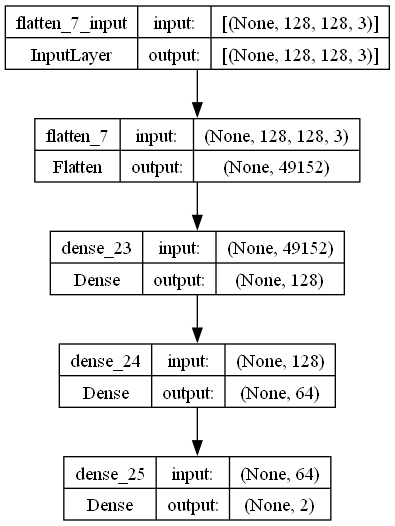

In [64]:
plot_model(model, show_shapes=True, show_layer_names=True)

C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


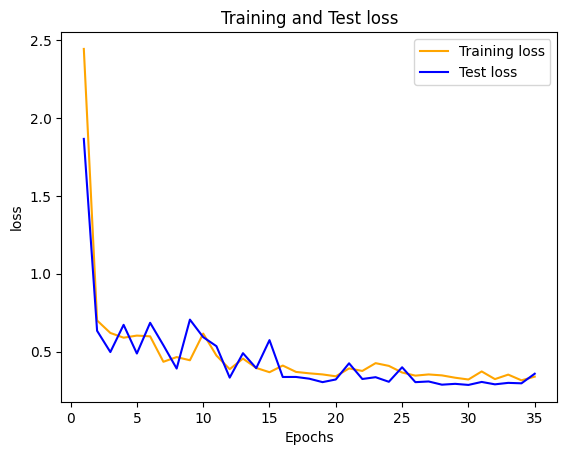

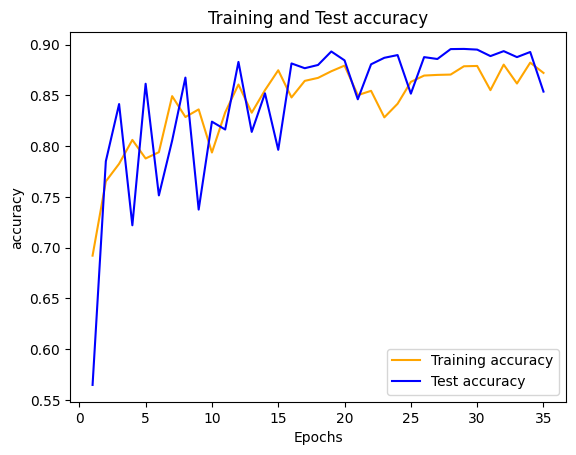

In [65]:
check_metrics(history, 'loss')
check_metrics(history, 'accuracy')

186/186 [==============================] - 8s 41ms/step


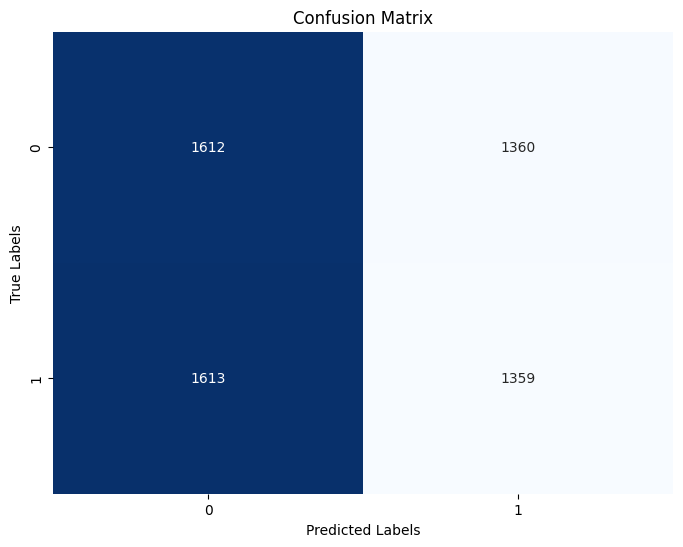

In [66]:
plot_confusion(model)

In [67]:
test_epoch_time(model)

186/186 [==============================] - 8s 41ms/step


7.938040018081665

### ANN Complexe

In [68]:
chosen_model_name = 'complicated_ann_model'
history = models_augmented[chosen_model_name]['history']
model = models_augmented[chosen_model_name]['model']

In [69]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 49152)             0         
                                                                 
 dense_26 (Dense)            (None, 256)               12583168  
                                                                 
 dense_27 (Dense)            (None, 128)               32896     
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 dense_29 (Dense)            (None, 128)               8320      
                                                                 
 dense_30 (Dense)            (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)               

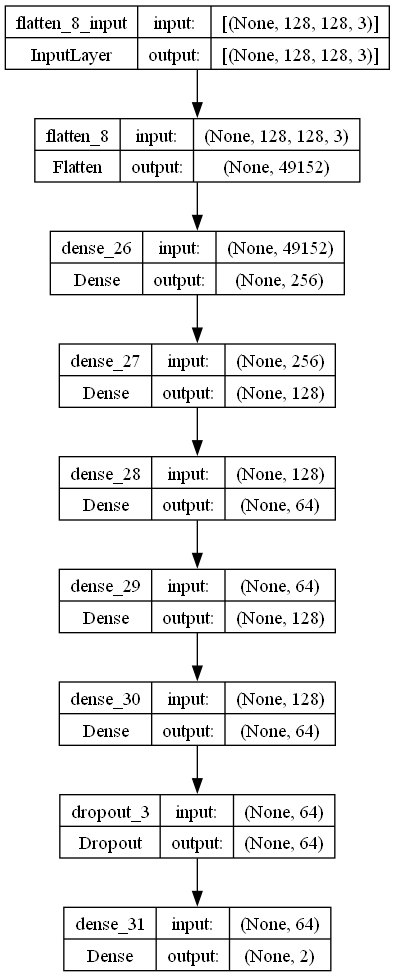

In [70]:
plot_model(model, show_shapes=True, show_layer_names=True)

C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


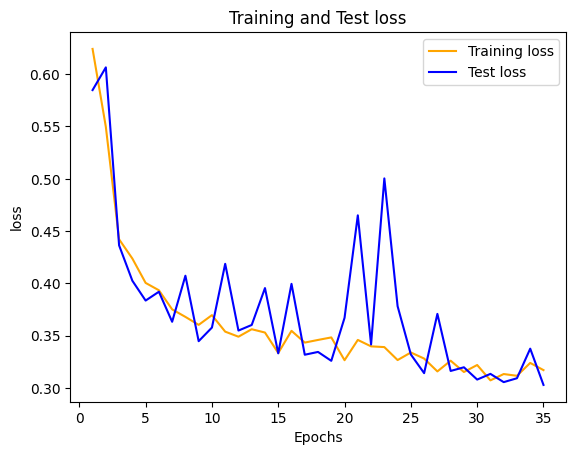

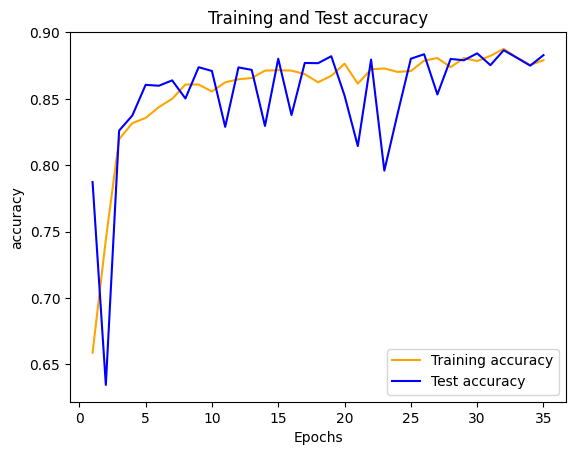

In [71]:
check_metrics(history, 'loss')
check_metrics(history, 'accuracy')

186/186 [==============================] - 8s 41ms/step


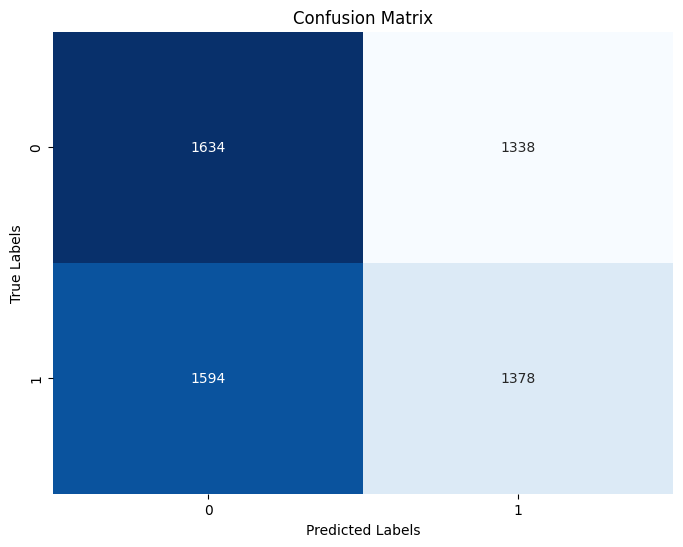

In [72]:
plot_confusion(model)

In [73]:
test_epoch_time(model)

186/186 [==============================] - 8s 41ms/step


7.938783884048462

### CNN Simple

In [74]:
chosen_model_name = 'simple_cnn_model'
history = models_augmented[chosen_model_name]['history']
model = models_augmented[chosen_model_name]['model']

In [75]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 57600)             0         
                                                                 
 dense_32 (Dense)            (None, 128)              

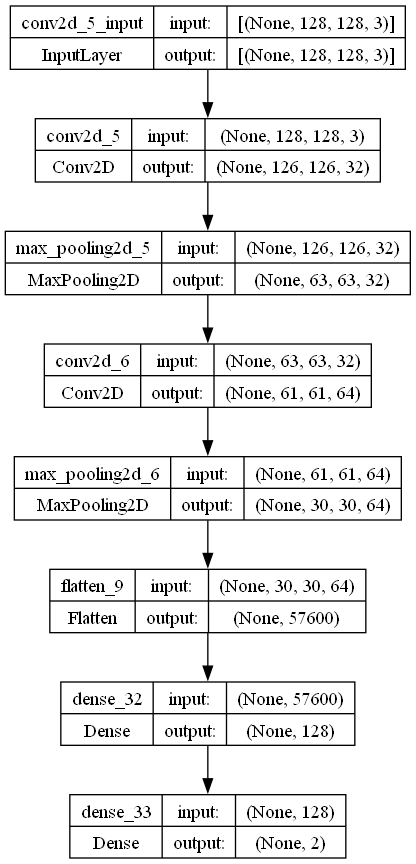

In [76]:
plot_model(model, show_shapes=True, show_layer_names=True)

C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


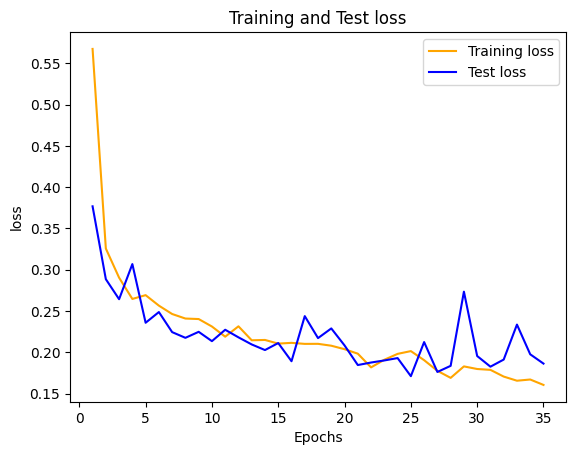

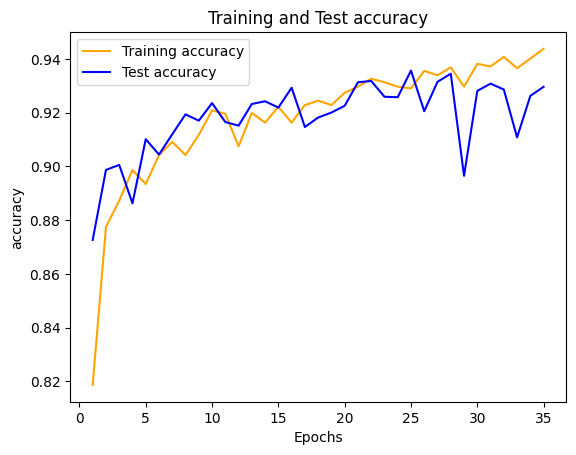

In [77]:
check_metrics(history, 'loss')
check_metrics(history, 'accuracy')

186/186 [==============================] - 8s 42ms/step


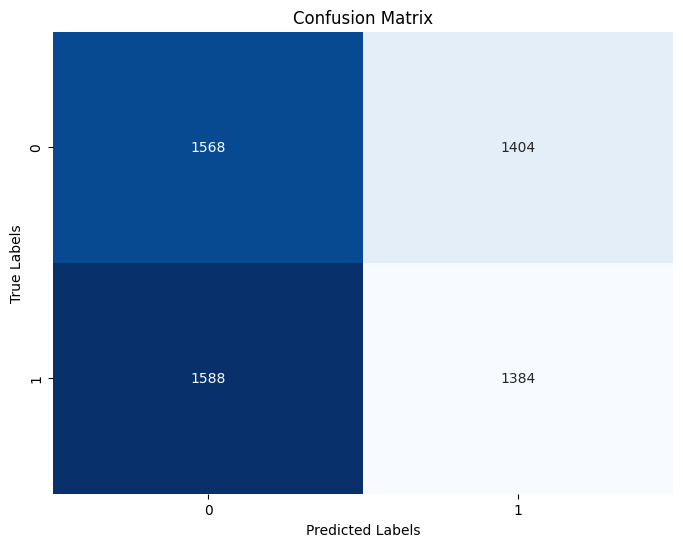

In [78]:
plot_confusion(model)

In [79]:
test_epoch_time(model)

186/186 [==============================] - 8s 43ms/step


8.268172025680542

### CNN Complexe

In [80]:
chosen_model_name = 'complicated_cnn_model'
history = models_augmented[chosen_model_name]['history']
model = models_augmented[chosen_model_name]['model']

In [81]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 128)    

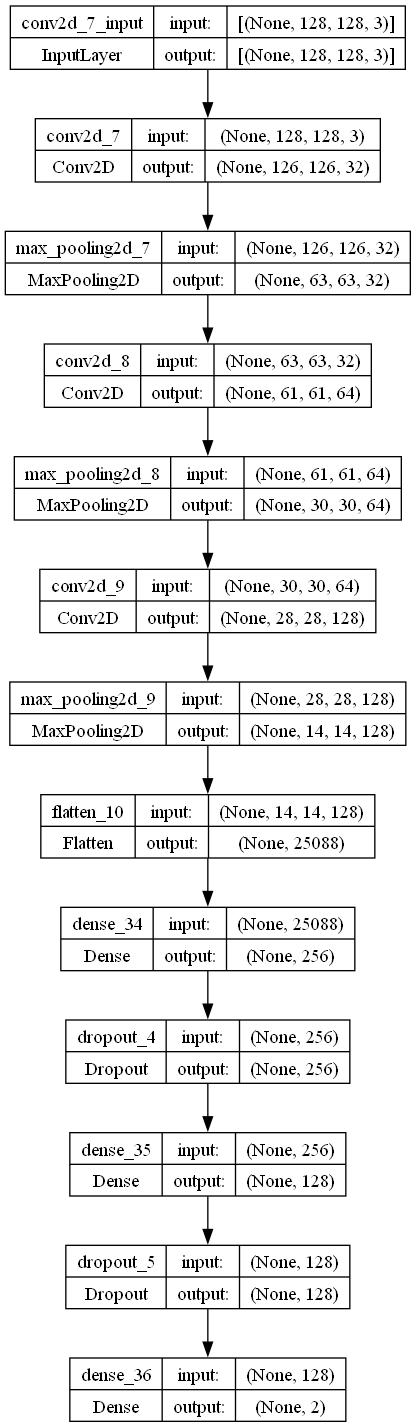

In [82]:
plot_model(model, show_shapes=True, show_layer_names=True)

C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


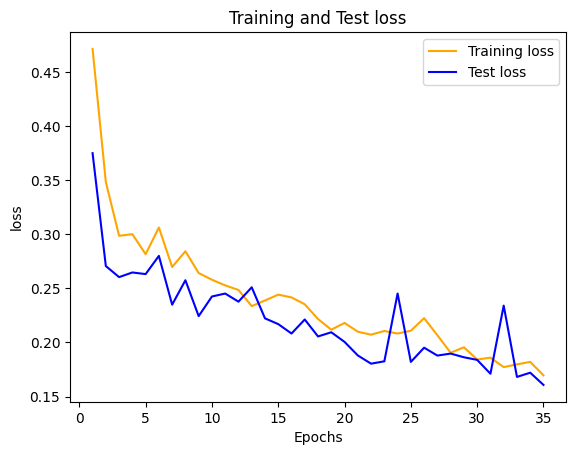

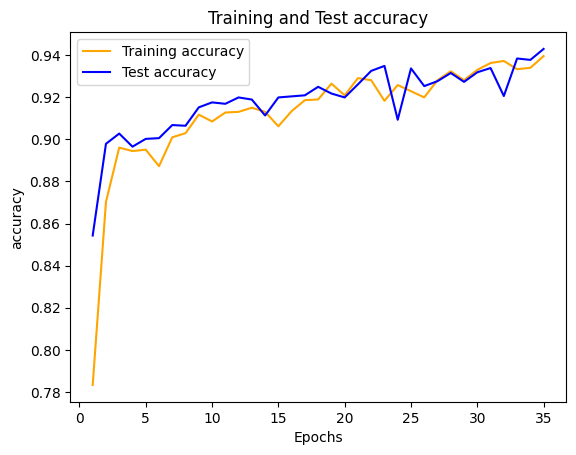

In [83]:
check_metrics(history, 'loss')
check_metrics(history, 'accuracy')

186/186 [==============================] - 8s 42ms/step


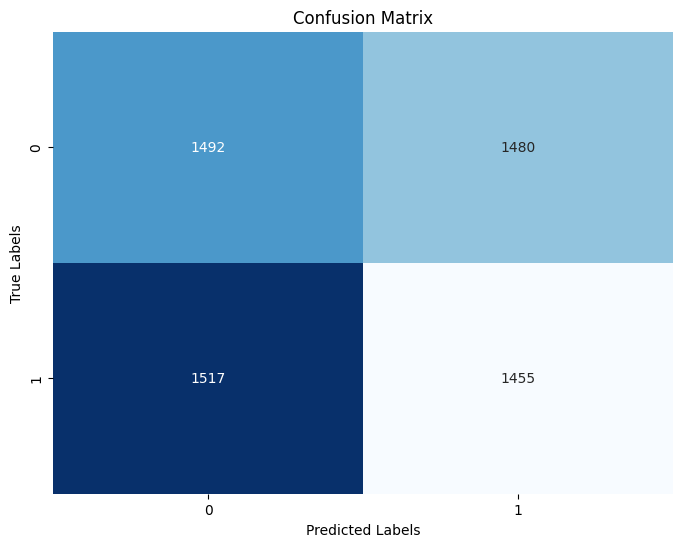

In [84]:
plot_confusion(model)

In [85]:
test_epoch_time(model)

  1/186 [..............................] - ETA: 21s

186/186 [==============================] - 8s 42ms/step


8.168863534927368

### Transfer learning avec vgg (frozen base)

In [86]:
chosen_model_name = 'transfer_vgg_model'
history = models_augmented[chosen_model_name]['history']
model = models_augmented[chosen_model_name]['model']

In [87]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_14 (Dense)            (None, 256)               2097408   
                                                                 
 dense_15 (Dense)            (None, 128)               32896     
                                                                 
 dense_16 (Dense)            (None, 2)                 258       
                                                                 
Total params: 16,845,250
Trainable params: 16,845,250
Non-trainable params: 0
_________________________________________________________________


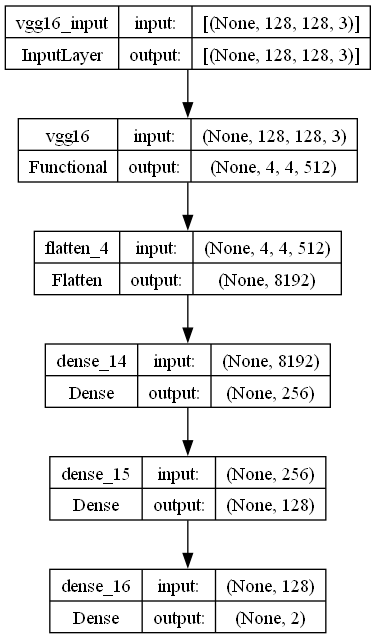

In [88]:
plot_model(model, show_shapes=True, show_layer_names=True)

C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


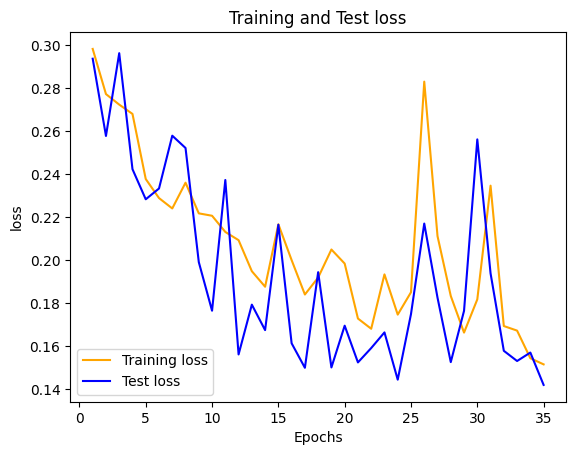

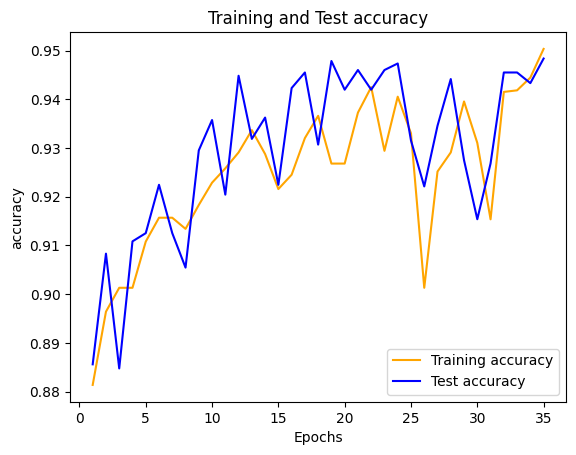

In [89]:
check_metrics(history, 'loss')
check_metrics(history, 'accuracy')

186/186 [==============================] - 10s 53ms/step


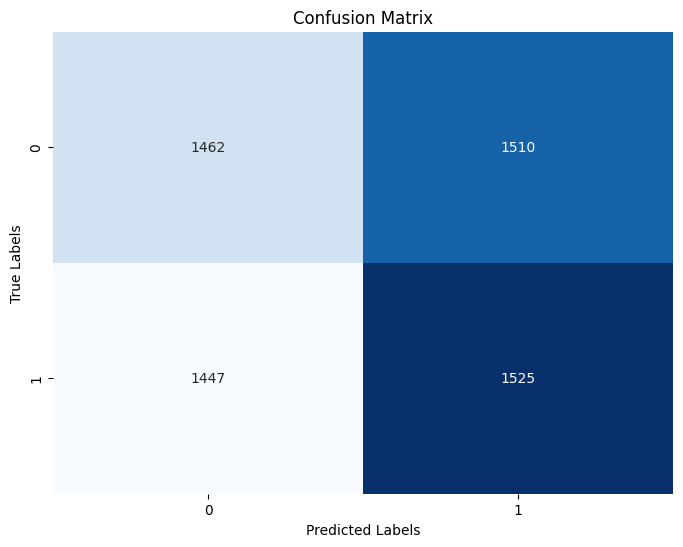

In [90]:
plot_confusion(model)


In [91]:
test_epoch_time(model)

186/186 [==============================] - 10s 52ms/step


10.006033897399902

### Transfer learning avec vgg

In [92]:
chosen_model_name = 'transfer_vgg_model_unfrozen'
history = models_augmented[chosen_model_name]['history']
model = models_augmented[chosen_model_name]['model']

In [93]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_17 (Dense)            (None, 256)               2097408   
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                                 
 dense_19 (Dense)            (None, 2)                 258       
                                                                 
Total params: 16,845,250
Trainable params: 16,845,250
Non-trainable params: 0
_________________________________________________________________


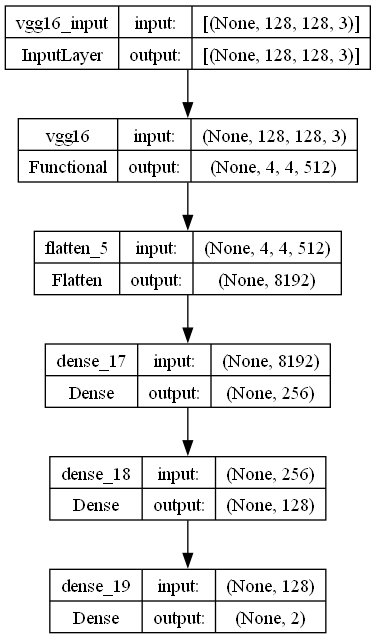

In [94]:
plot_model(model, show_shapes=True, show_layer_names=True)

C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


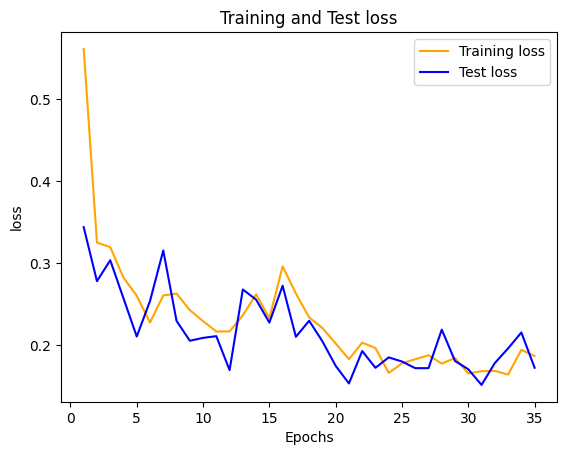

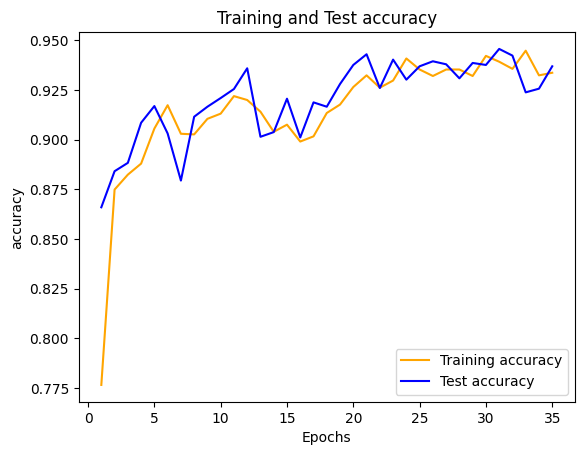

In [95]:
check_metrics(history, 'loss')
check_metrics(history, 'accuracy')

186/186 [==============================] - 10s 52ms/step


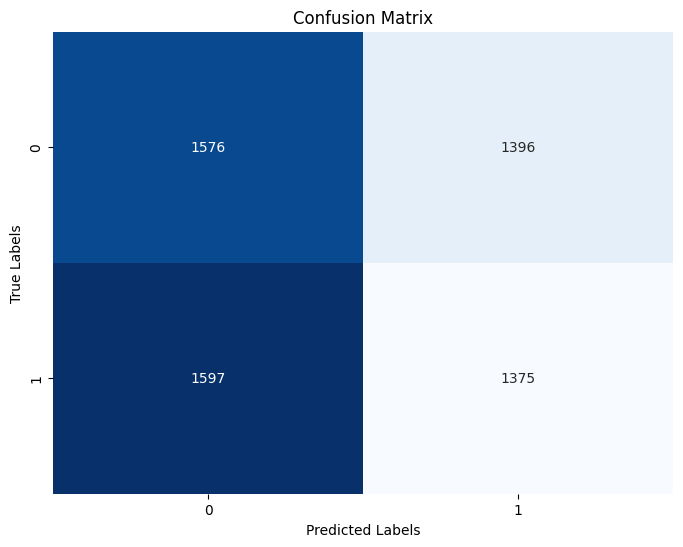

In [96]:
plot_confusion(model)

In [97]:
test_epoch_time(model)

186/186 [==============================] - 10s 52ms/step


9.921971321105957

### Transfer learning avec resnet (frozen base)

In [98]:
chosen_model_name = 'transfer_resnet_model'
history = models_augmented[chosen_model_name]['history']
model = models_augmented[chosen_model_name]['model']

In [99]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_6 (Flatten)         (None, 32768)             0         
                                                                 
 dense_20 (Dense)            (None, 256)               8388864   
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 dense_22 (Dense)            (None, 2)                 258       
                                                                 
Total params: 32,009,730
Trainable params: 31,956,610
Non-trainable params: 53,120
_________________________________________________________________


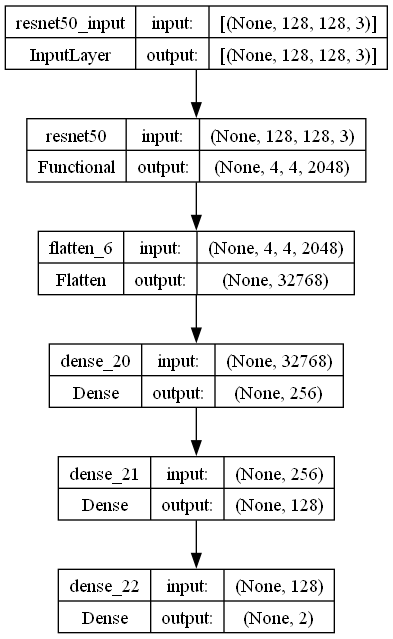

In [100]:
plot_model(model, show_shapes=True, show_layer_names=True)

C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


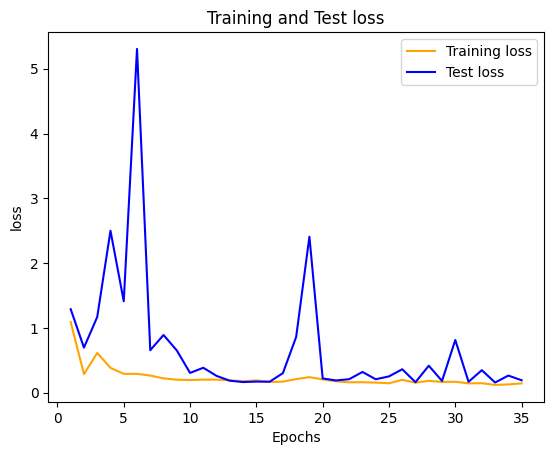

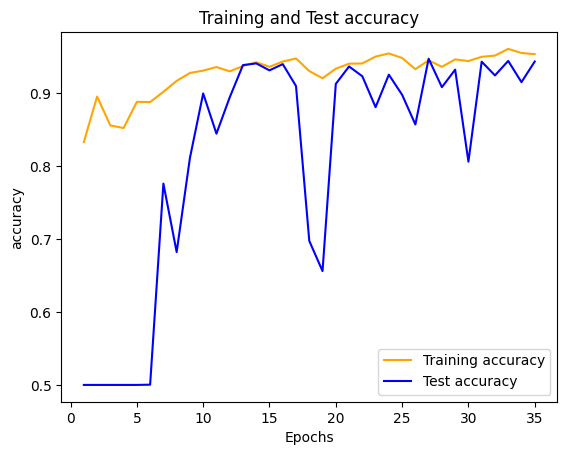

In [101]:
check_metrics(history, 'loss')
check_metrics(history, 'accuracy')

186/186 [==============================] - 12s 55ms/step


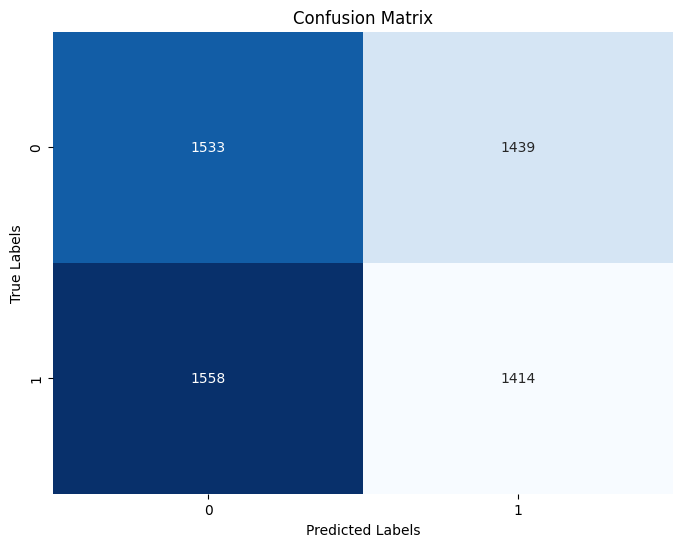

In [102]:
plot_confusion(model)

In [103]:
test_epoch_time(model)

186/186 [==============================] - 10s 55ms/step


10.59950065612793

## Comparaison des modeles

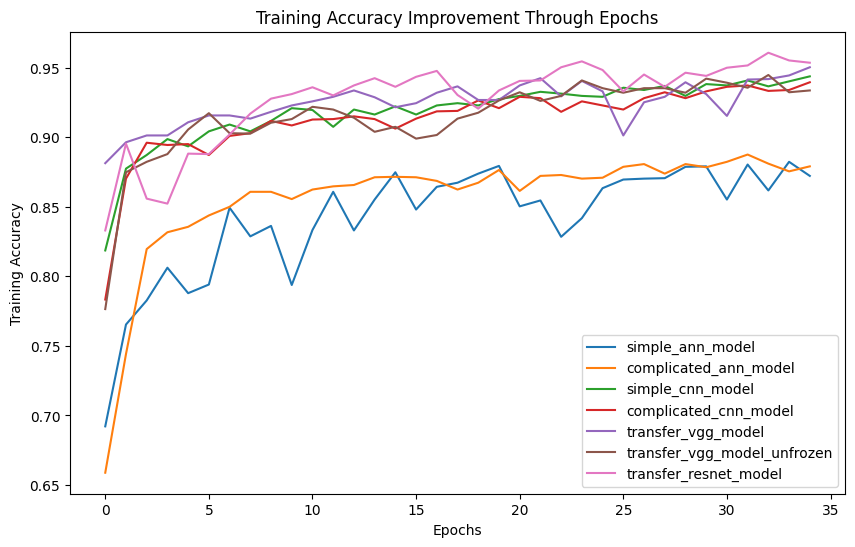

In [104]:
plot_training_accuracy(models_augmented)

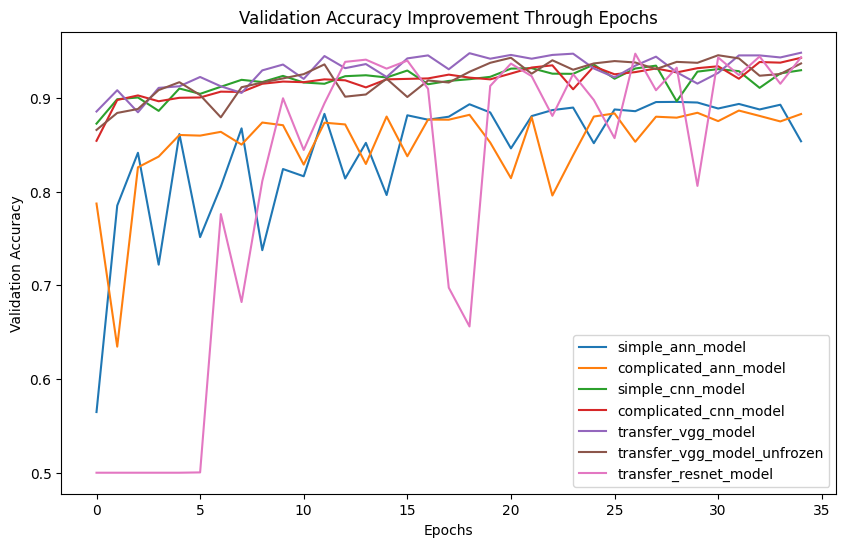

In [105]:
plot_validation_accuracy(models_augmented)

186/186 [==============================] - 10s 54ms/step


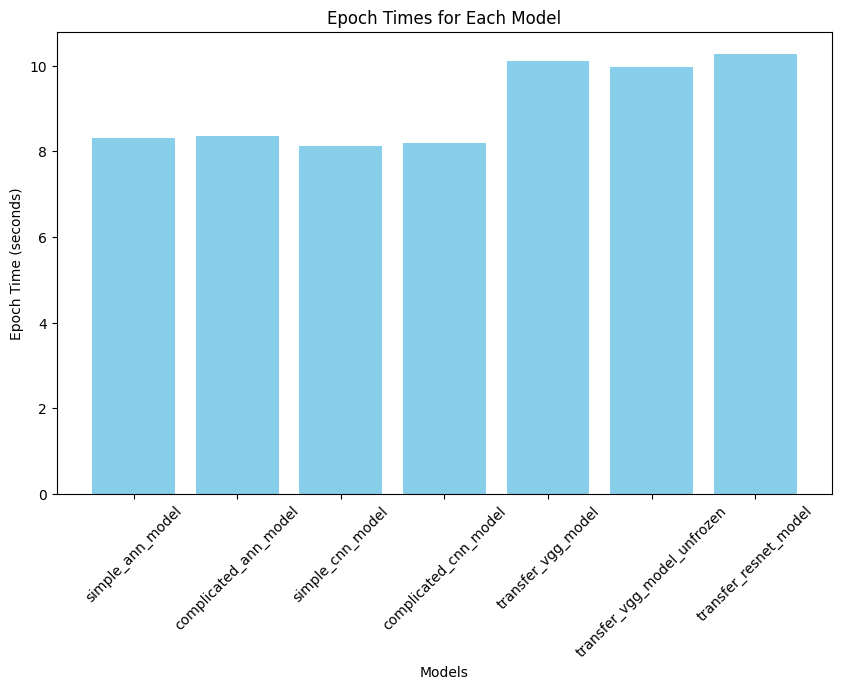

In [106]:
plot_epoch_times(models_augmented)

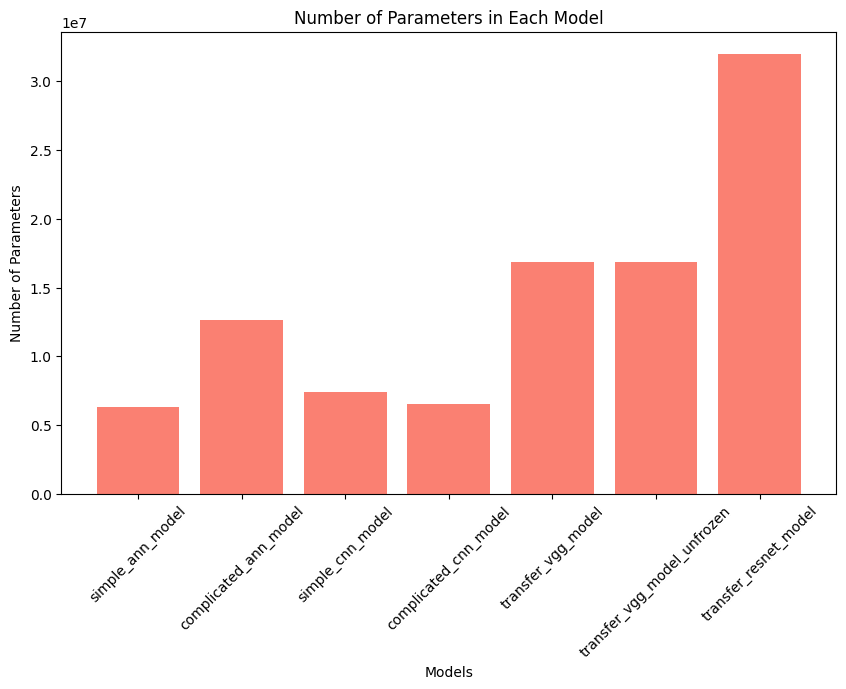

In [107]:
plot_number_of_parameters(models_augmented)

186/186 [==============================] - 8s 41ms/step


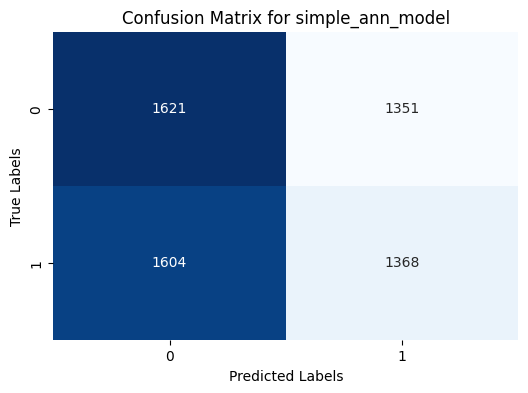

186/186 [==============================] - 8s 41ms/step


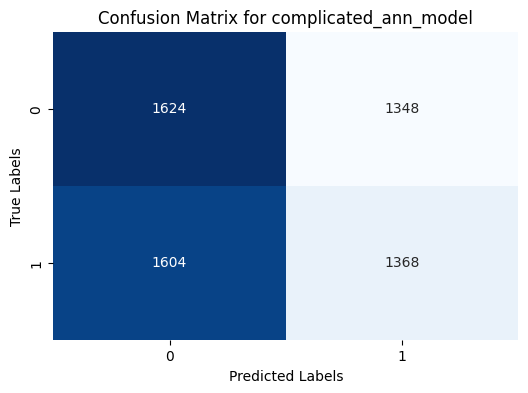

186/186 [==============================] - 8s 42ms/step


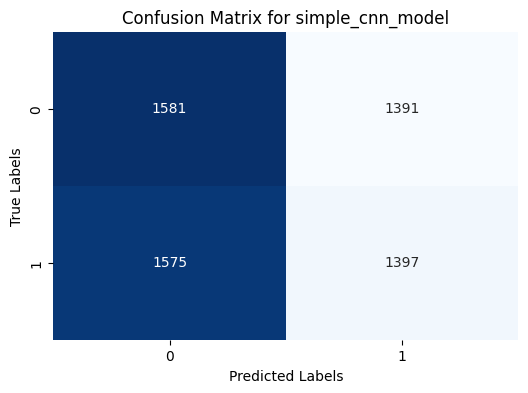

186/186 [==============================] - 8s 42ms/step


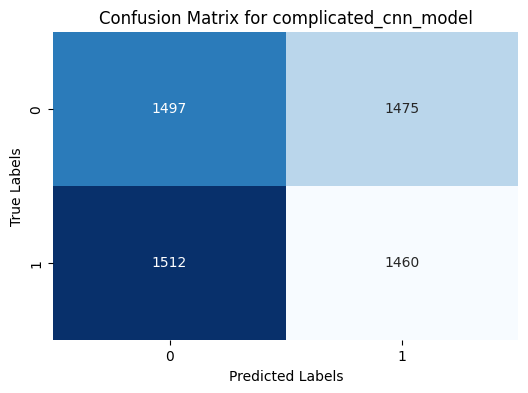

186/186 [==============================] - 10s 53ms/step


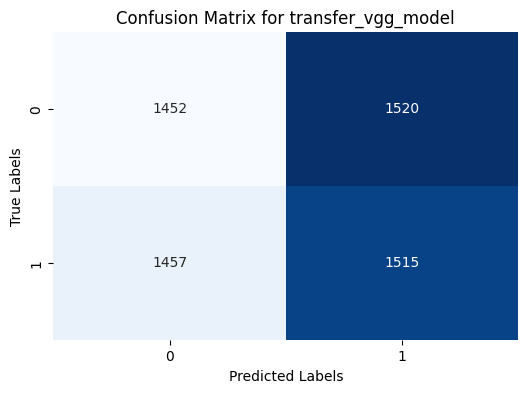

186/186 [==============================] - 10s 53ms/step


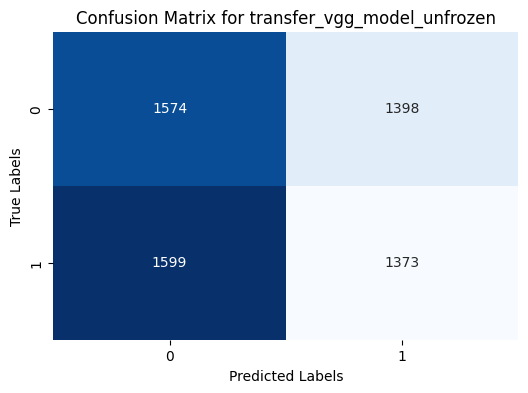

186/186 [==============================] - 11s 56ms/step


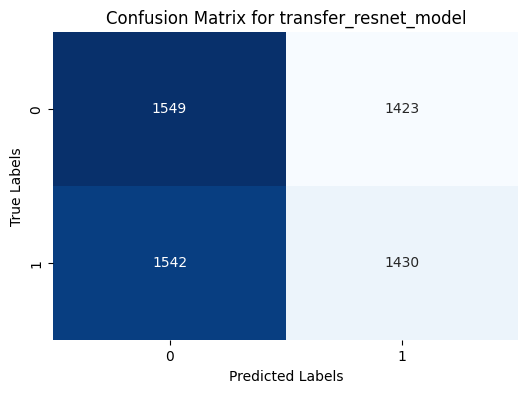

In [108]:
plot_confusion_matrices(models_augmented)

# Evaluation des modeles avec et sans transfer learning

## Evaluation Individuelle des modeles

### ANN Simple

In [109]:
chosen_model_name = 'simple_ann_model'

history_augmented = models_augmented[chosen_model_name]['history']
model_augmented = models_augmented[chosen_model_name]['model']

history = models[chosen_model_name]['history']
model = models[chosen_model_name]['model']

pour le cas avec augmentation de données


C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


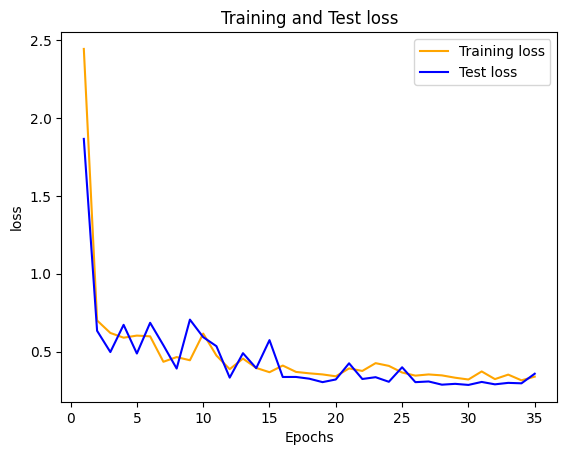

pour le cas sans augmentation de données


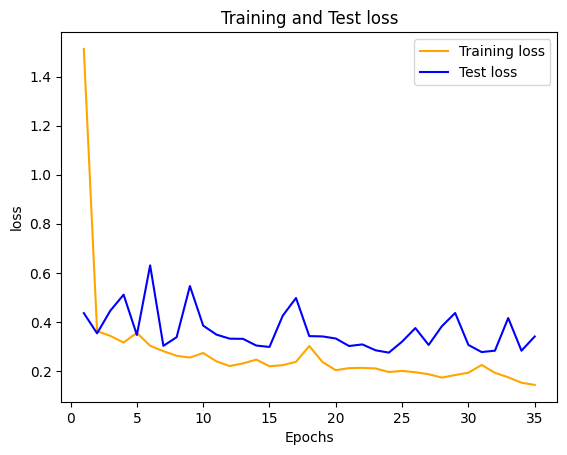

In [110]:
print("pour le cas avec augmentation de données")
check_metrics(history_augmented, 'loss')
print("pour le cas sans augmentation de données")
check_metrics(history, 'loss')

pour le cas avec augmentation de données


C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


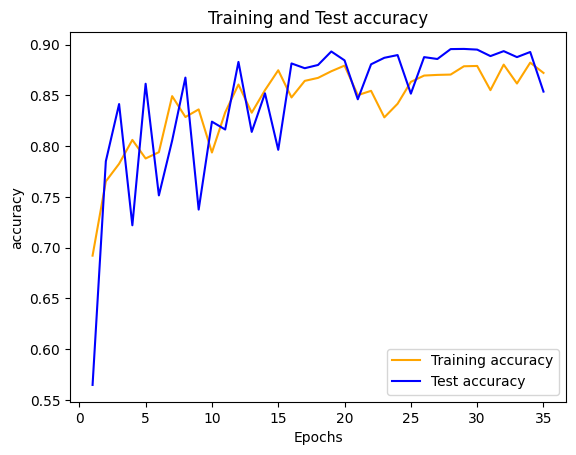

pour le cas sans augmentation de données


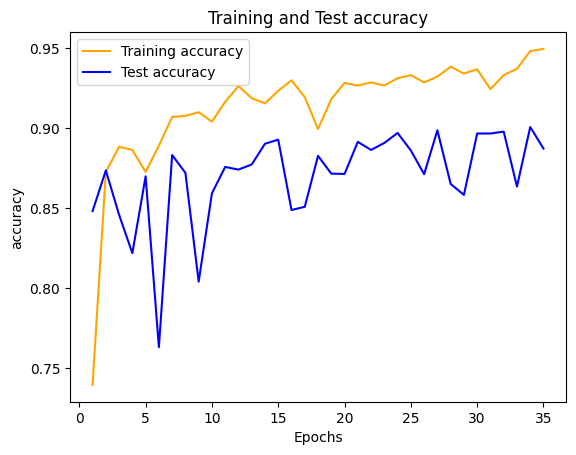

In [111]:
print("pour le cas avec augmentation de données")
check_metrics(history_augmented, 'accuracy')
print("pour le cas sans augmentation de données")
check_metrics(history, 'accuracy')

pour le cas avec augmentation de données
186/186 [==============================] - 8s 41ms/step


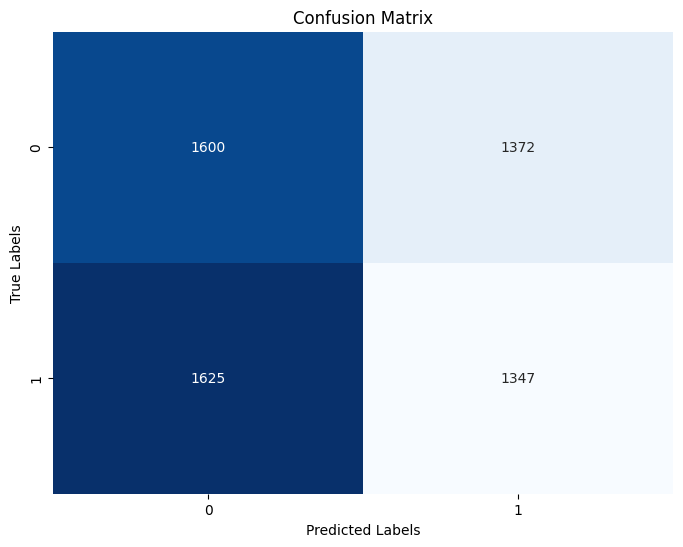

pour le sans augmentation de données
186/186 [==============================] - 8s 42ms/step


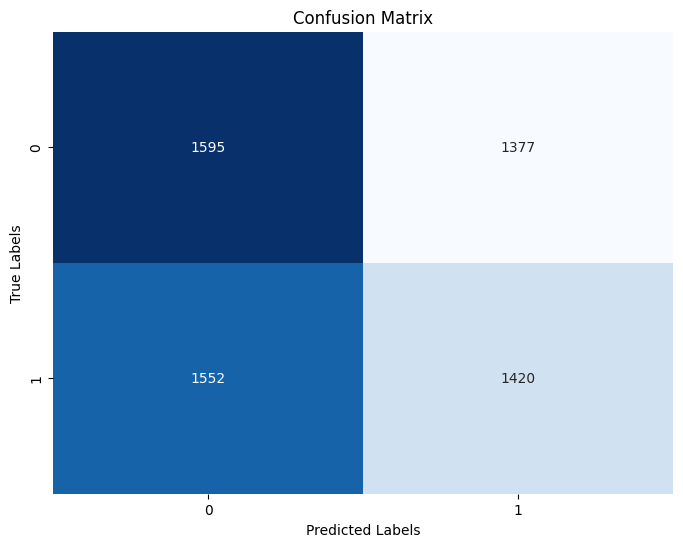

In [112]:
print("pour le cas avec augmentation de données")
plot_confusion(model_augmented)
print("pour le sans augmentation de données")
plot_confusion(model)

### ANN Complexe

In [113]:
chosen_model_name = 'complicated_ann_model'

history_augmented = models_augmented[chosen_model_name]['history']
model_augmented = models_augmented[chosen_model_name]['model']

history = models[chosen_model_name]['history']
model = models[chosen_model_name]['model']

pour le cas avec augmentation de données


C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


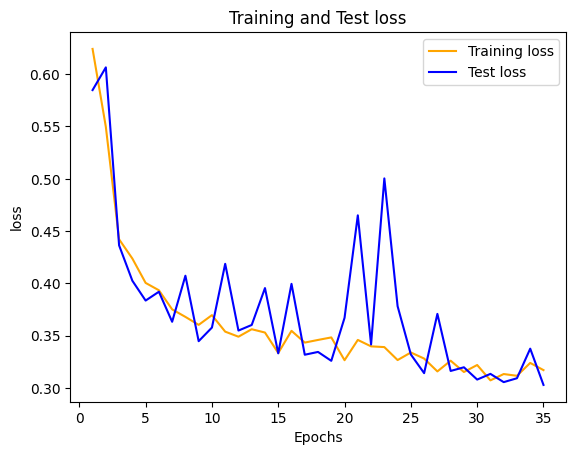

pour le cas sans augmentation de données


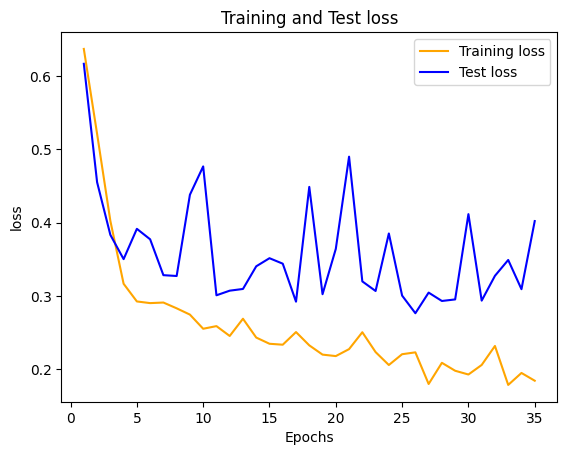

In [114]:
print("pour le cas avec augmentation de données")
check_metrics(history_augmented, 'loss')
print("pour le cas sans augmentation de données")
check_metrics(history, 'loss')

pour le cas avec augmentation de données


C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


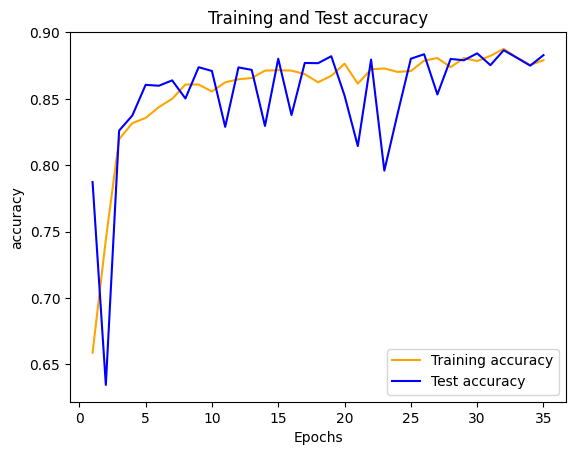

pour le cas sans augmentation de données


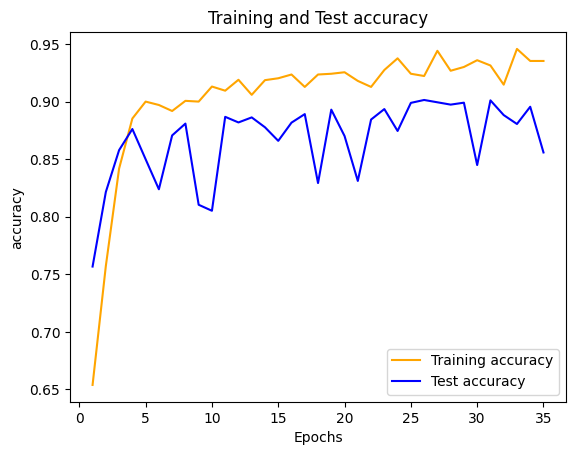

In [115]:
print("pour le cas avec augmentation de données")
check_metrics(history_augmented, 'accuracy')
print("pour le cas sans augmentation de données")
check_metrics(history, 'accuracy')

pour le cas avec augmentation de données
186/186 [==============================] - 8s 42ms/step


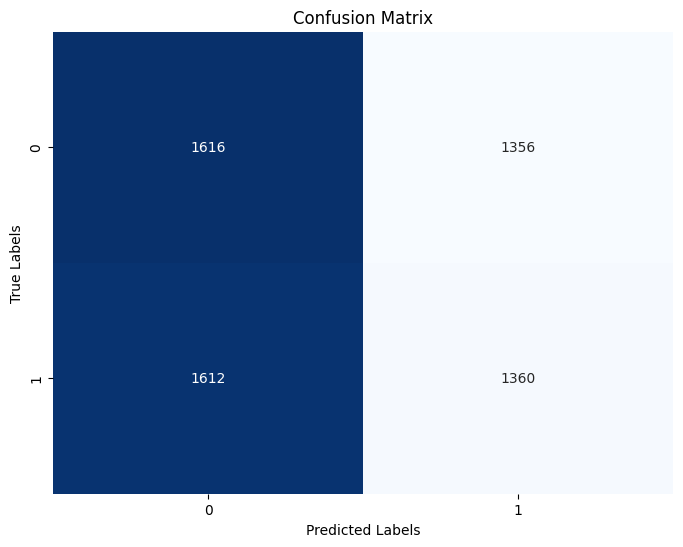

pour le sans augmentation de données
186/186 [==============================] - 8s 42ms/step


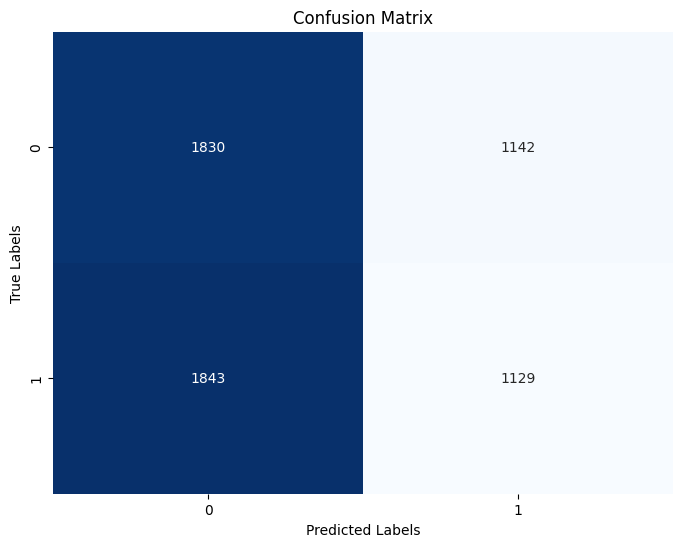

In [116]:
print("pour le cas avec augmentation de données")
plot_confusion(model_augmented)
print("pour le sans augmentation de données")
plot_confusion(model)

### CNN Simple

In [117]:
chosen_model_name = 'simple_cnn_model'

history_augmented = models_augmented[chosen_model_name]['history']
model_augmented = models_augmented[chosen_model_name]['model']

history = models[chosen_model_name]['history']
model = models[chosen_model_name]['model']

pour le cas avec augmentation de données


C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


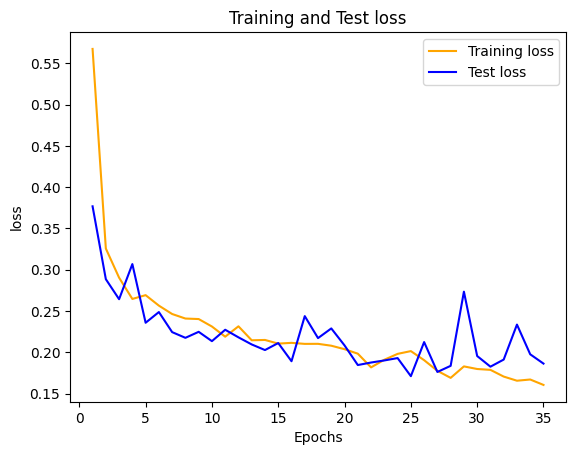

pour le cas sans augmentation de données


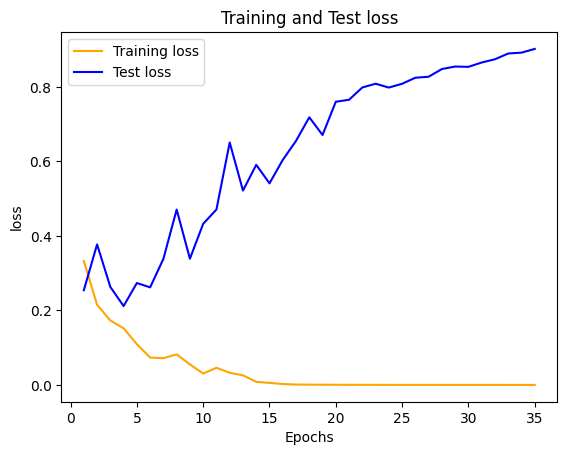

In [118]:
print("pour le cas avec augmentation de données")
check_metrics(history_augmented, 'loss')
print("pour le cas sans augmentation de données")
check_metrics(history, 'loss')

pour le cas avec augmentation de données


C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


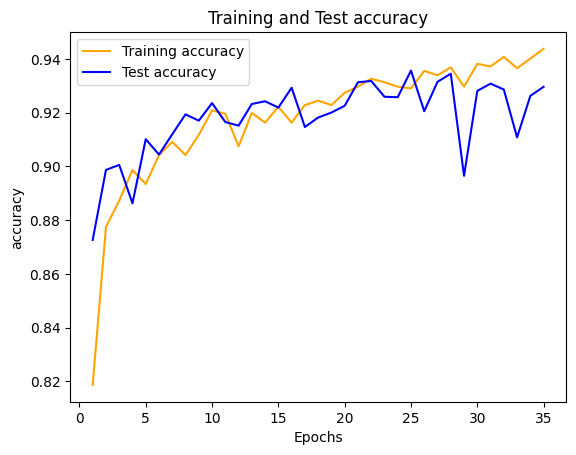

pour le cas sans augmentation de données


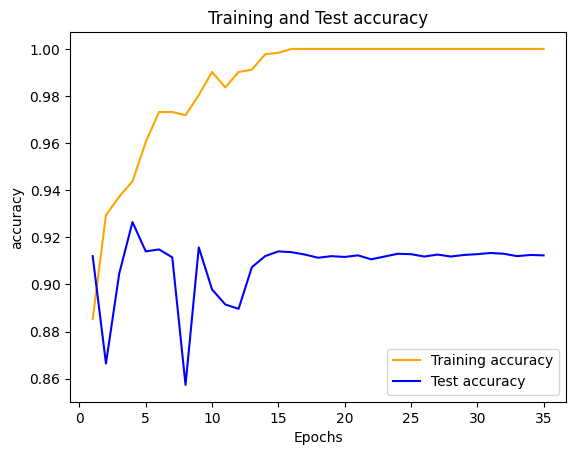

In [119]:
print("pour le cas avec augmentation de données")
check_metrics(history_augmented, 'accuracy')
print("pour le cas sans augmentation de données")
check_metrics(history, 'accuracy')

pour le cas avec augmentation de données
186/186 [==============================] - 8s 44ms/step


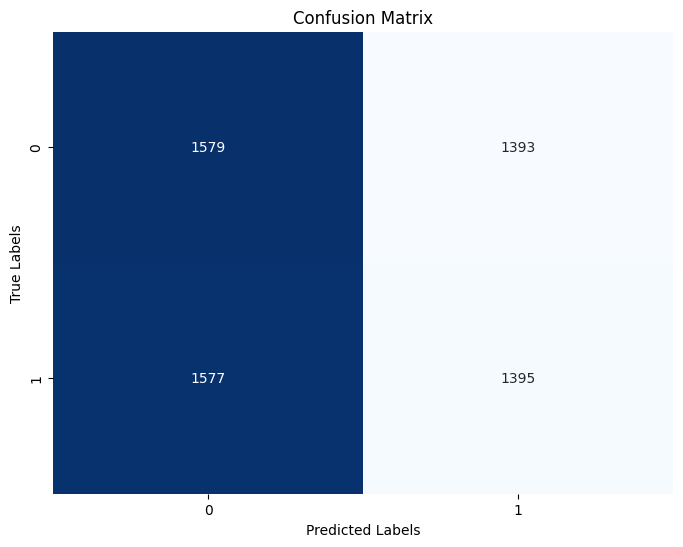

pour le sans augmentation de données
186/186 [==============================] - 8s 42ms/step


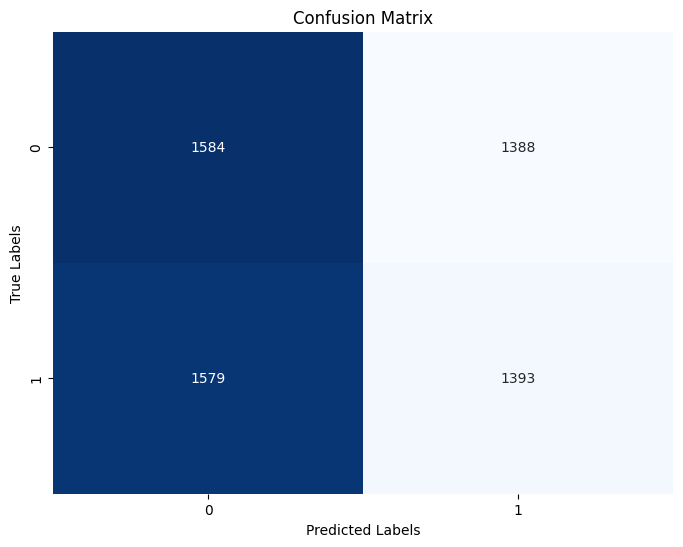

In [120]:
print("pour le cas avec augmentation de données")
plot_confusion(model_augmented)
print("pour le sans augmentation de données")
plot_confusion(model)

### CNN Complexe

In [121]:
chosen_model_name = 'complicated_cnn_model'

history_augmented = models_augmented[chosen_model_name]['history']
model_augmented = models_augmented[chosen_model_name]['model']

history = models[chosen_model_name]['history']
model = models[chosen_model_name]['model']

pour le cas avec augmentation de données


C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


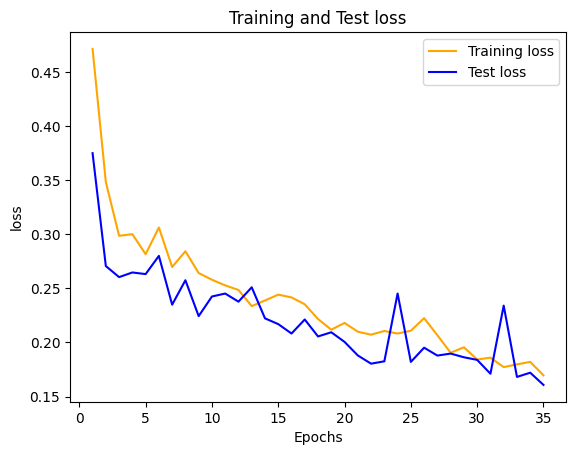

pour le cas sans augmentation de données


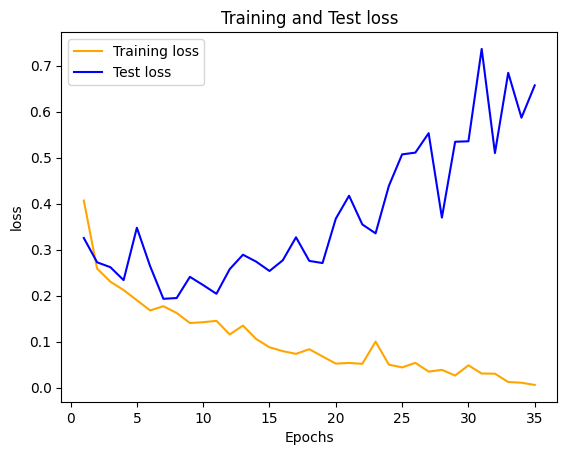

In [122]:
print("pour le cas avec augmentation de données")
check_metrics(history_augmented, 'loss')
print("pour le cas sans augmentation de données")
check_metrics(history, 'loss')

pour le cas avec augmentation de données


C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


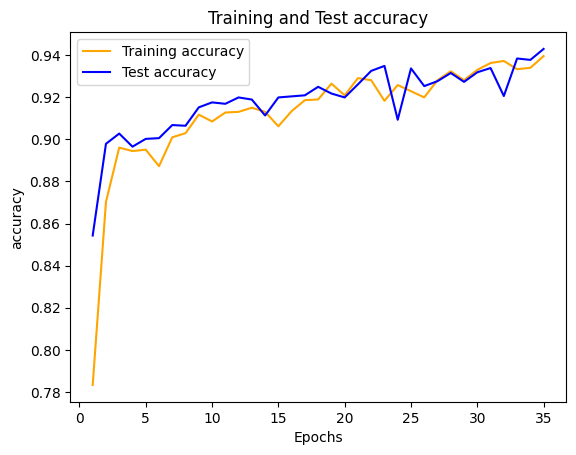

pour le cas sans augmentation de données


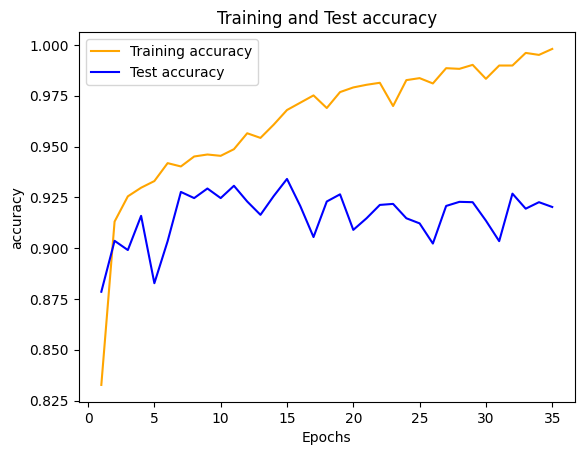

In [123]:
print("pour le cas avec augmentation de données")
check_metrics(history_augmented, 'accuracy')
print("pour le cas sans augmentation de données")
check_metrics(history, 'accuracy')

pour le cas avec augmentation de données
186/186 [==============================] - 8s 42ms/step


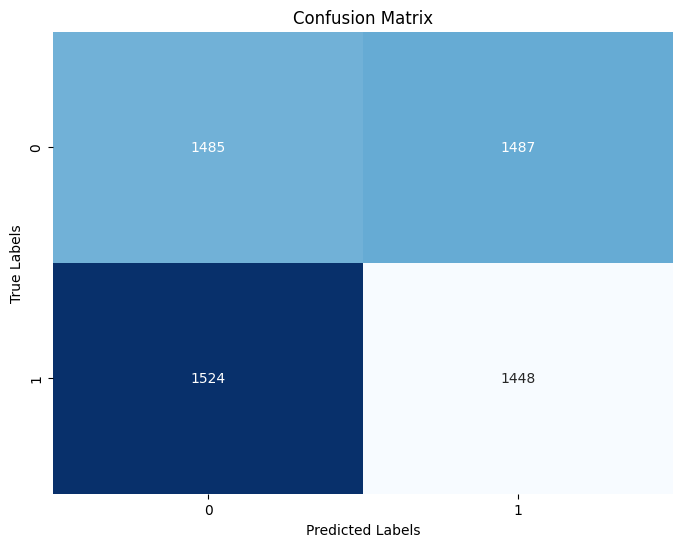

pour le sans augmentation de données
186/186 [==============================] - 8s 43ms/step


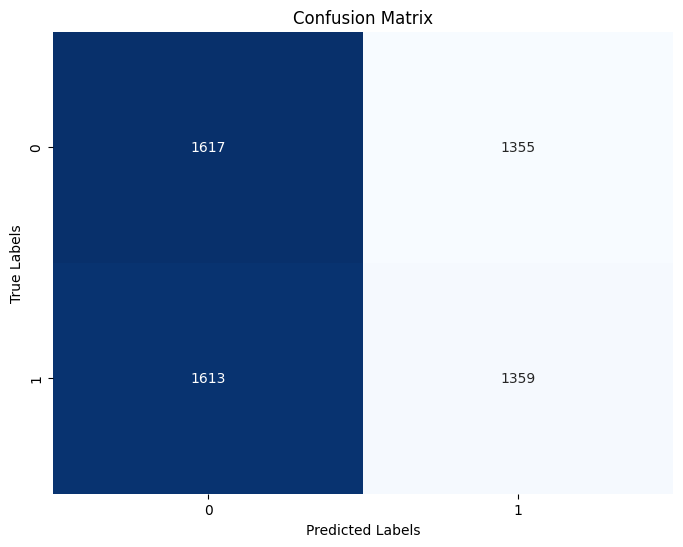

In [124]:
print("pour le cas avec augmentation de données")
plot_confusion(model_augmented)
print("pour le sans augmentation de données")
plot_confusion(model)

###  Transfer learning avec vgg (frozen base)

In [125]:
chosen_model_name = 'transfer_resnet_model'

history_augmented = models_augmented[chosen_model_name]['history']
model_augmented = models_augmented[chosen_model_name]['model']

history = models[chosen_model_name]['history']
model = models[chosen_model_name]['model']

pour le cas avec augmentation de données


C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


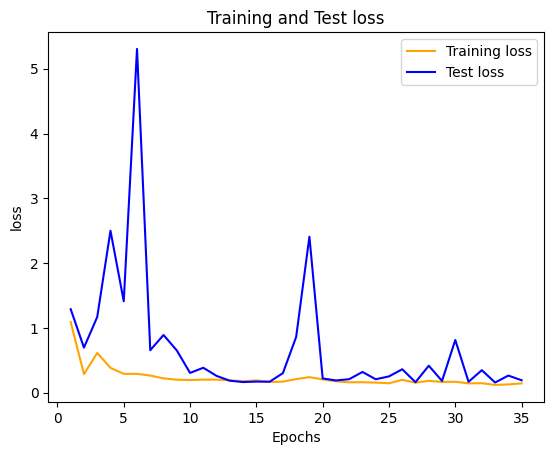

pour le cas sans augmentation de données


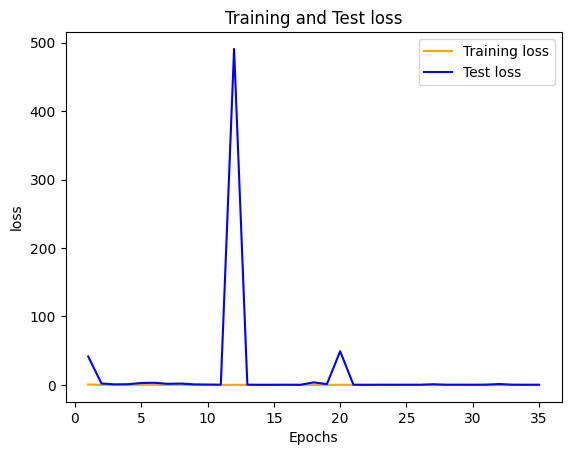

In [126]:
print("pour le cas avec augmentation de données")
check_metrics(history_augmented, 'loss')
print("pour le cas sans augmentation de données")
check_metrics(history, 'loss')

pour le cas avec augmentation de données


C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


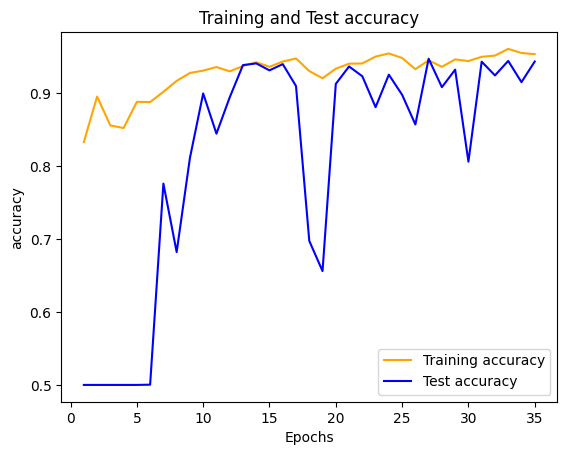

pour le cas sans augmentation de données


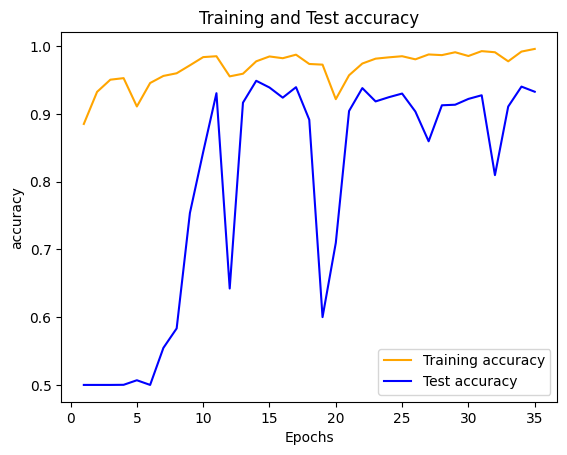

In [127]:
print("pour le cas avec augmentation de données")
check_metrics(history_augmented, 'accuracy')
print("pour le cas sans augmentation de données")
check_metrics(history, 'accuracy')

pour le cas avec augmentation de données
186/186 [==============================] - 11s 58ms/step


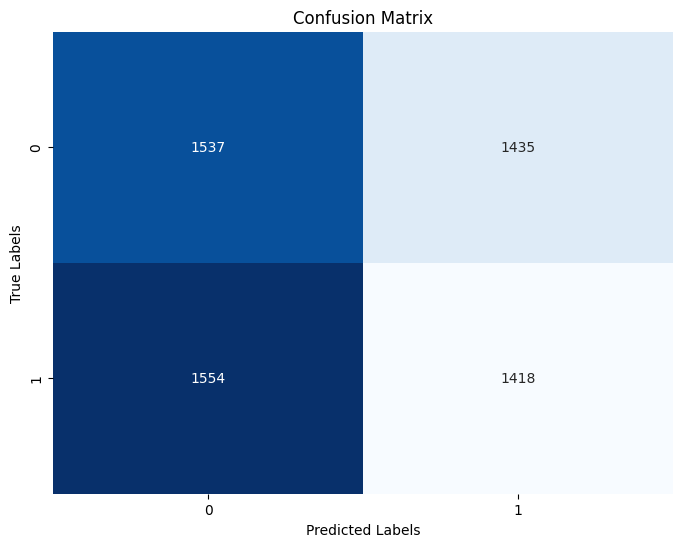

pour le sans augmentation de données
186/186 [==============================] - 11s 57ms/step


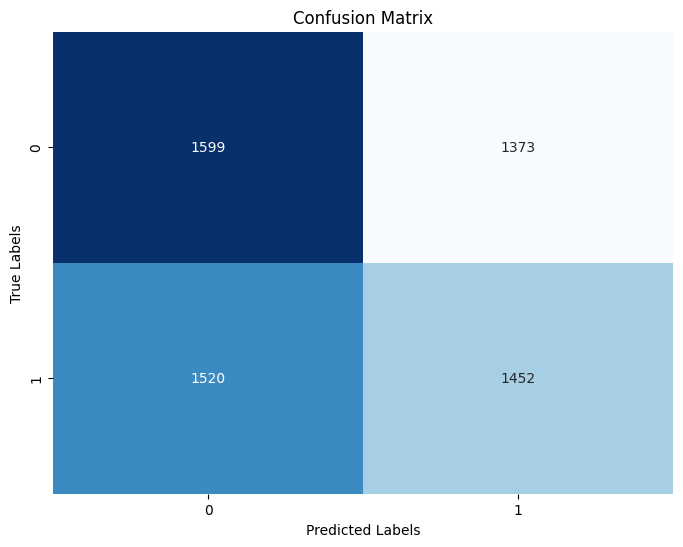

In [128]:
print("pour le cas avec augmentation de données")
plot_confusion(model_augmented)
print("pour le sans augmentation de données")
plot_confusion(model)

### Transfer learning avec vgg (unfrozen base)

In [129]:
chosen_model_name = 'transfer_vgg_model_unfrozen'

history_augmented = models_augmented[chosen_model_name]['history']
model_augmented = models_augmented[chosen_model_name]['model']

history = models[chosen_model_name]['history']
model = models[chosen_model_name]['model']

pour le cas avec augmentation de données


C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


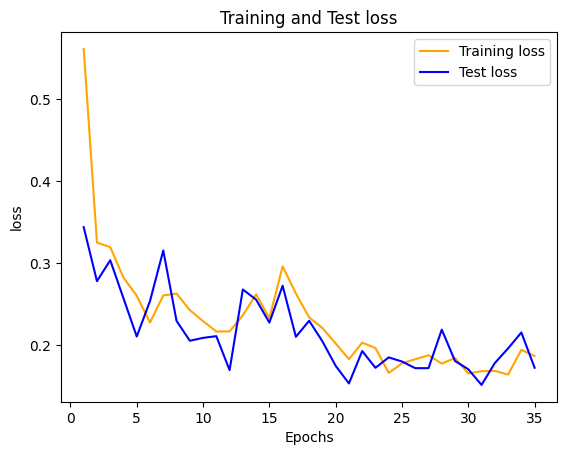

pour le cas sans augmentation de données


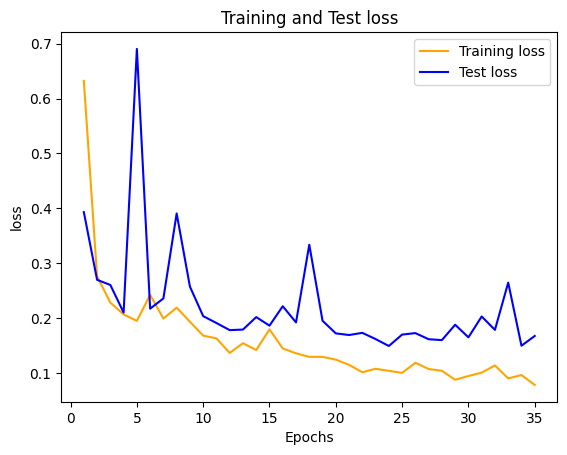

In [130]:
print("pour le cas avec augmentation de données")
check_metrics(history_augmented, 'loss')
print("pour le cas sans augmentation de données")
check_metrics(history, 'loss')

pour le cas avec augmentation de données


C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


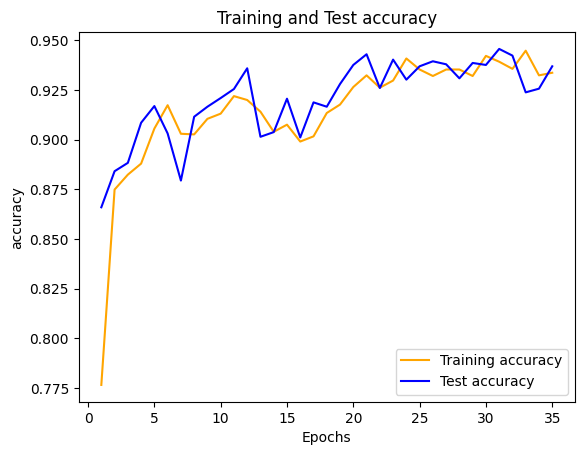

pour le cas sans augmentation de données


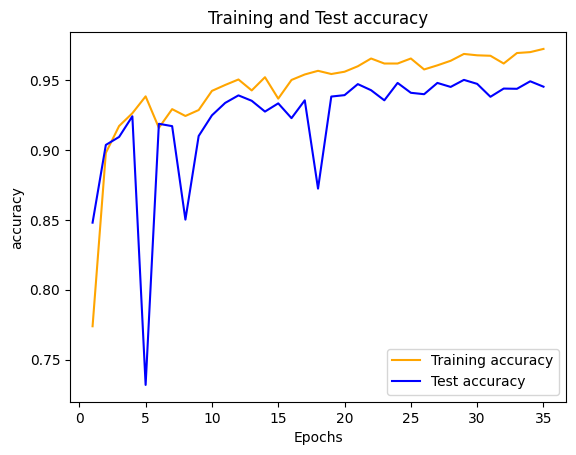

In [131]:
print("pour le cas avec augmentation de données")
check_metrics(history_augmented, 'accuracy')
print("pour le cas sans augmentation de données")
check_metrics(history, 'accuracy')

pour le cas avec augmentation de données
186/186 [==============================] - 10s 53ms/step


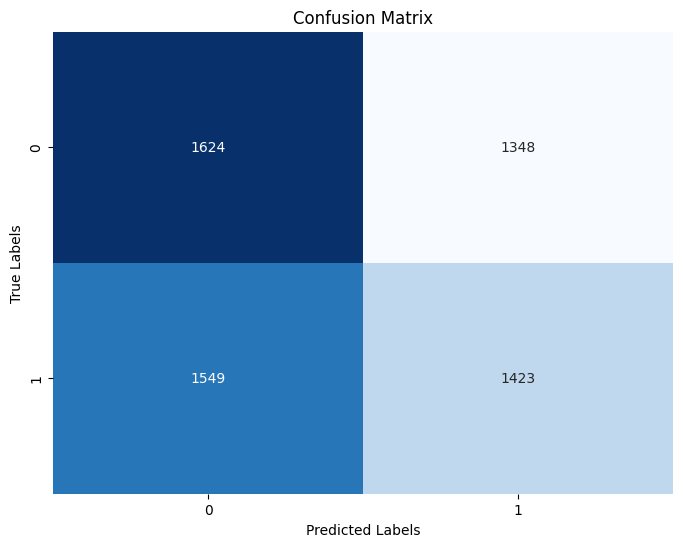

pour le sans augmentation de données
186/186 [==============================] - 10s 53ms/step


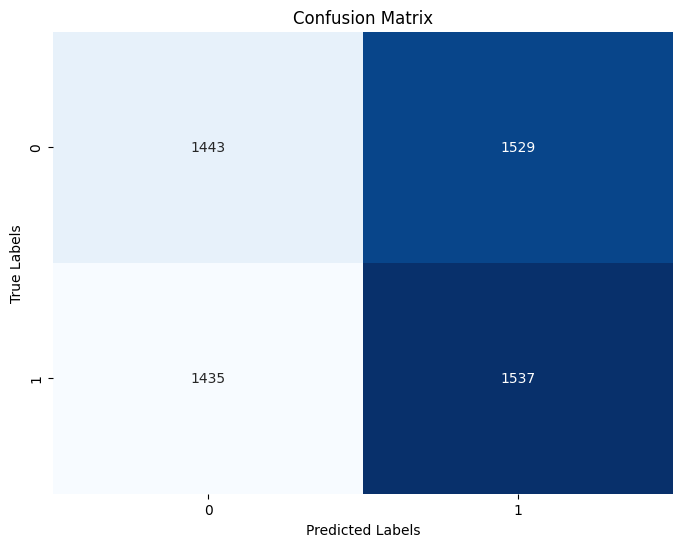

In [132]:
print("pour le cas avec augmentation de données")
plot_confusion(model_augmented)
print("pour le sans augmentation de données")
plot_confusion(model)

### Transfer learning avec resnet (frozen base)

In [133]:
chosen_model_name = 'transfer_resnet_model'

history_augmented = models_augmented[chosen_model_name]['history']
model_augmented = models_augmented[chosen_model_name]['model']

history = models[chosen_model_name]['history']
model = models[chosen_model_name]['model']

pour le cas avec augmentation de données


C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


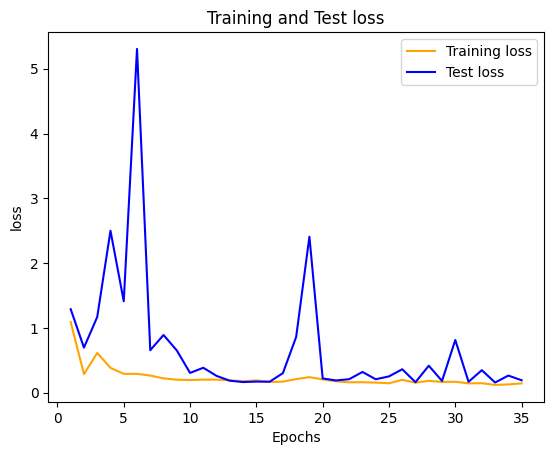

pour le cas sans augmentation de données


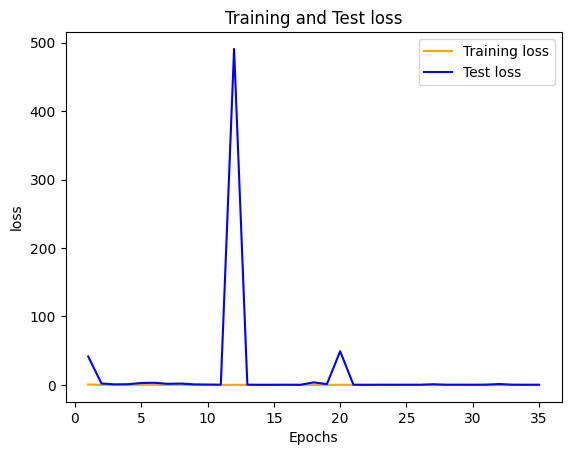

In [134]:
print("pour le cas avec augmentation de données")
check_metrics(history_augmented, 'loss')
print("pour le cas sans augmentation de données")
check_metrics(history, 'loss')

pour le cas avec augmentation de données


C:\Users\Mahdi\AppData\Local\Temp\ipykernel_16016\546351312.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')


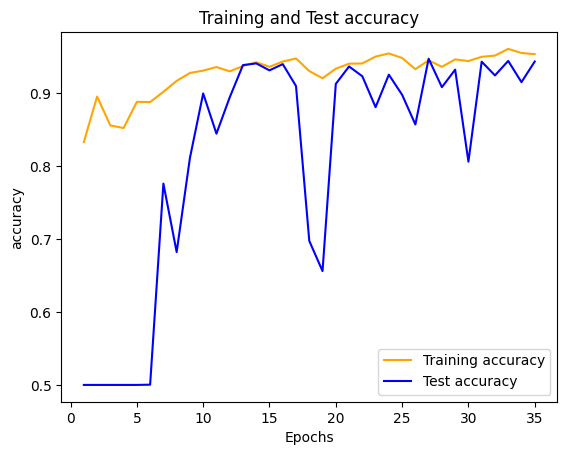

pour le cas sans augmentation de données


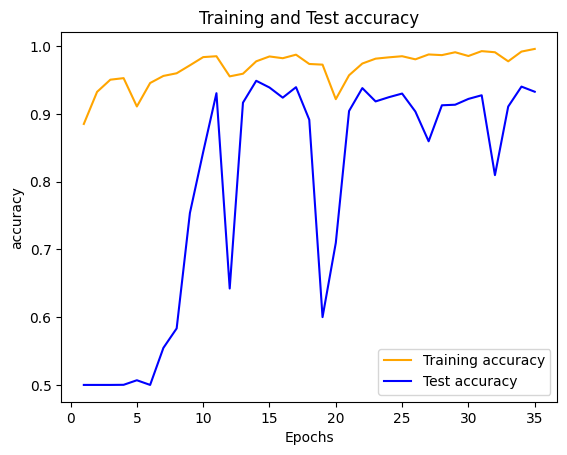

In [135]:
print("pour le cas avec augmentation de données")
check_metrics(history_augmented, 'accuracy')
print("pour le cas sans augmentation de données")
check_metrics(history, 'accuracy')

pour le cas avec augmentation de données
186/186 [==============================] - 10s 56ms/step


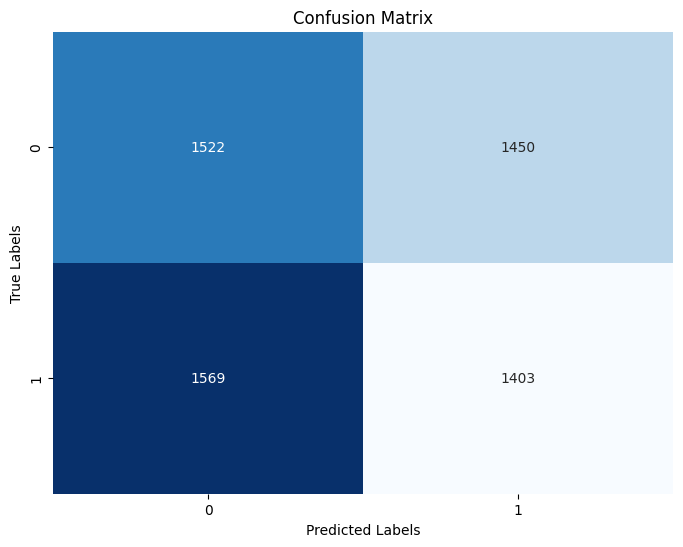

pour le sans augmentation de données
186/186 [==============================] - 10s 51ms/step


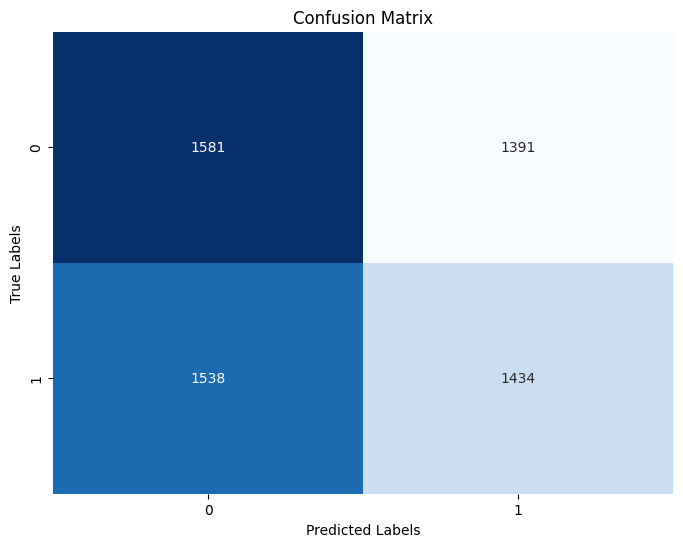

In [136]:
print("pour le cas avec augmentation de données")
plot_confusion(model_augmented)
print("pour le sans augmentation de données")
plot_confusion(model)

## Comparaison des modeles

pour le cas avec augmentation de données


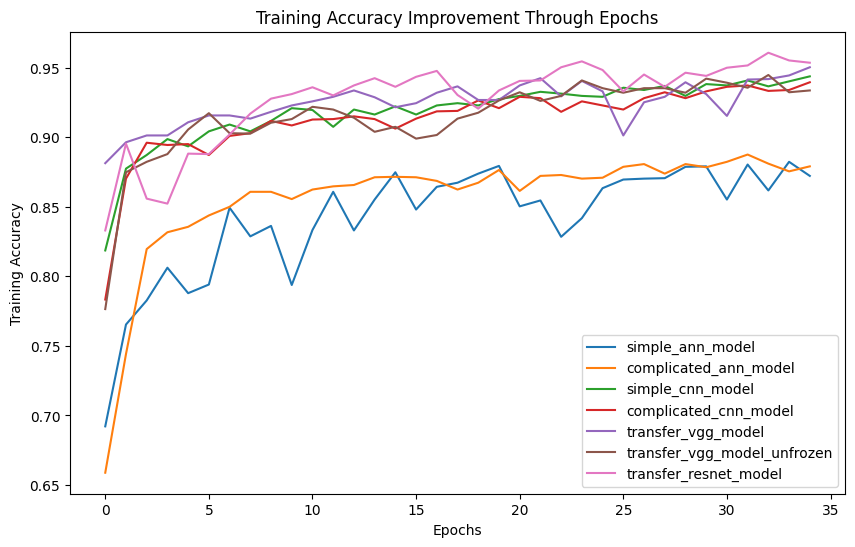

pour le sans augmentation de données


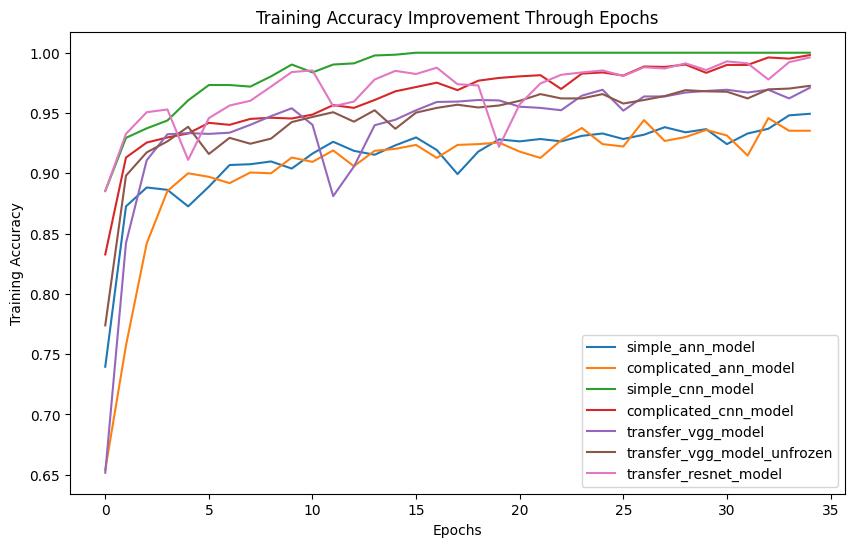

In [137]:
print("pour le cas avec augmentation de données")
plot_training_accuracy(models_augmented)
print("pour le sans augmentation de données")
plot_training_accuracy(models)

pour le sans augmentation de données


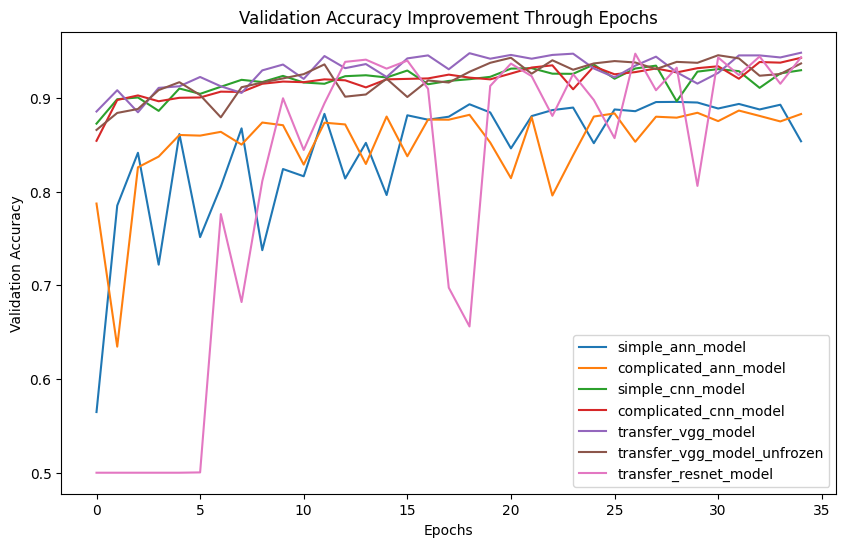

pour le sans augmentation de données


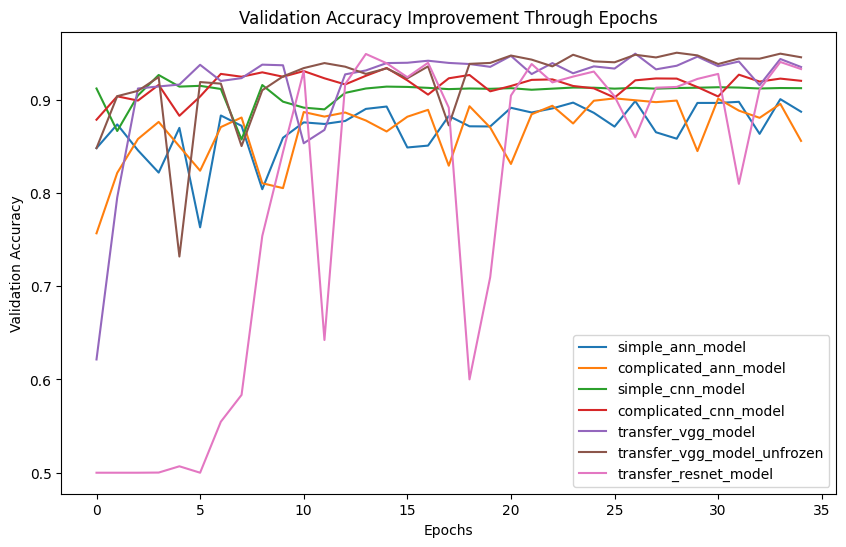

In [138]:
print("pour le sans augmentation de données")
plot_validation_accuracy(models_augmented)
print("pour le sans augmentation de données")
plot_validation_accuracy(models)

# Object detection

In [139]:
# Load pre-trained face detection and mask detection models
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
mask_model = load_model(r'saved_models/with_data_augmentation/simple_ann_model_model.h5')

# Function to detect face and predict mask
def detect_mask(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    for (x, y, w, h) in faces:
        face_roi = frame[y:y+h, x:x+w]
        face_roi = cv2.resize(face_roi, (128, 128))  # Resize to match model input size
        face_roi = cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB)  # Convert to RGB

        face_roi = face_roi.astype('float') / 255.0
        face_roi = np.expand_dims(face_roi, axis=0)  # Add batch dimension

        mask_result = mask_model.predict(face_roi)
        if mask_result[0][0] > mask_result[0][1]:  # Assuming [mask, no_mask] classes
            label = "Mask"
            color = (0, 255, 0)  # Green for wearing a mask
        else:
            label = "No Mask"
            color = (0, 0, 255)  # Red for not wearing a mask

        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    return frame

# Open webcam
cap = cv2.VideoCapture(0)  # Use 0 for the default webcam

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = detect_mask(frame)
    cv2.imshow('Mask Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 37ms/step
